# Analysis of material properties of mitochondrial membranes

## Loading and setup

In [1]:
%load_ext autoreload


In [2]:
%matplotlib inline
%autoreload 1
import pickle
import numpy as np
from functools import partial
import MDAnalysis

from pathlib import Path

import matplotlib.pyplot as plt
import numpy.typing as npt

import pandas as pd

from scipy import integrate, interpolate, stats
from scipy.optimize import curve_fit
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map

%aimport util
from plot_helper import *


Matplotlib Version: 3.6.3


In [3]:
plot_styles = [
    ("./white_background_ctl.mplstyle", ""),
    ("./dark_background_ctl.mplstyle", "_dark"),
]


In [4]:
def radial_averaging(power2D, mc, min_bin=0.001, max_bin=1, bin_width=0.001):
    """
    Radially average the power spectrum to obtain values. Notably the natural freqeuncy unit
    of this function is A^-1.

    Args:
        power2D (numpy.array((N,N))): Power spectrum
        mc (_type_): Membrane curvature object with metadata
        min_bin (float, optional): Minimum bin value. Defaults to 0.001.
        max_bin (int, optional): Maximum bin value. Defaults to 1.
        bin_width (float, optional): Bin width. Defaults to 0.001.

    Returns:
        tuple: Binned power spectra
    """
    x, y = np.meshgrid(mc["qx"], mc["qy"])  # A^-1
    r = np.sqrt(x**2 + y**2)
    bins = np.arange(min_bin, max_bin, bin_width)

    digitized = np.digitize(r, bins)
    bc = np.array(
        [
            r[digitized == i].mean() if np.count_nonzero(digitized == i) else np.NAN
            for i in range(1, len(bins))
        ]
    )
    bm = np.array(
        [
            power2D[digitized == i].mean()
            if np.count_nonzero(digitized == i)
            else np.NAN
            for i in range(1, len(bins))
        ]
    )

    bin_centers = bc[np.isfinite(bm)]
    bin_means = bm[np.isfinite(bm)]

    return np.column_stack((bin_centers, bin_means, bin_centers**4 * bin_means))


def radial_averaging_series(power2D, mc, min_bin=0.001, max_bin=1, bin_width=0.001):
    """
    Perform radial averaging over multiple frames in a time series.

    Radially average the power spectrum to obtain values. Notably the natural freqeuncy unit
    of this function is A^-1.

    Args:
        power2D (numpy.array((M,N,N))): Power spectrum
        mc (_type_): Membrane curvature object with metadata
        min_bin (float, optional): Minimum bin value. Defaults to 0.001.
        max_bin (int, optional): Maximum bin value. Defaults to 1.
        bin_width (float, optional): Bin width. Defaults to 0.001.

    Returns:
        tuple: Binned power spectra
    """

    if not len(power2D.shape) == 3:
        raise RuntimeError("Expected time series of 2D power")

    x, y = np.meshgrid(mc["qx"], mc["qy"])  # A^-1
    r = np.sqrt(x**2 + y**2)
    bins = np.arange(min_bin, max_bin, bin_width)

    digitized = np.digitize(r, bins)
    bc = np.array(
        [
            r[digitized == i].mean() if np.count_nonzero(digitized == i) else np.NAN
            for i in range(1, len(bins))
        ]
    )

    first_iter = True

    spectra = None

    for i, frame in tqdm(enumerate(power2D), total=len(power2D)):
        bm = np.array(
            [
                frame[digitized == i].mean()
                if np.count_nonzero(digitized == i)
                else np.NAN
                for i in range(1, len(bins))
            ]
        )

        if i == 0:
            bin_centers = bc[np.isfinite(bm)]
            bin_means = bm[np.isfinite(bm)]
            spectra = np.zeros((power2D.shape[0], len(bin_means)))
            spectra[i] = bin_means
        else:
            spectra[i] = bm[np.isfinite(bm)]
    return (bin_centers, spectra)


# def radial_averaging_nm(power2D, mc, min_bin=0.1, max_bin=10, bin_width=0.1):
#     x, y = np.meshgrid(mc.qx * 10, mc.qy * 10)  # convert to nm^-1
#     r = np.sqrt(x**2 + y**2)
#     bins = np.arange(min_bin, max_bin, bin_width)

#     digitized = np.digitize(r, bins)
#     bc = np.array(
#         [
#             r[digitized == i].mean() if np.count_nonzero(digitized == i) else np.NAN
#             for i in range(1, len(bins))
#         ]
#     )
#     bm = np.array(
#         [
#             power2D[digitized == i].mean()
#             if np.count_nonzero(digitized == i)
#             else np.NAN
#             for i in range(1, len(bins))
#         ]
#     )

#     bin_centers = bc[np.isfinite(bm)]
#     bin_means = bm[np.isfinite(bm)]

#     return np.column_stack((bin_centers, bin_means, bin_centers**4 * bin_means))


def count_residues(u):
    count_dict = {}
    for residue in u.residues:
        if residue.resname not in count_dict:
            count_dict[residue.resname] = 1
        else:
            count_dict[residue.resname] += 1
    return count_dict


### System information

In [5]:
def get_compositions(sim):
    top = util.sim_path / str(sim) / "system.top"

    raw_composition = {}
    with open(top, "r") as fd:
        molecules_flag = False
        for line in fd:
            if molecules_flag:
                line = line.split(";")[0]
                if line:
                    r, n = line.split()
                    if r in raw_composition:
                        raw_composition[r] += int(n)
                    else:
                        raw_composition[r] = int(n)
            else:
                if "[ molecules ]" in line:
                    molecules_flag = True

    total_lipids = 0
    for lipid in util.lipid_names:
        if lipid in raw_composition:
            total_lipids += raw_composition[lipid]

    normed_composition = {}
    s = ""
    for lipid in util.lipid_names:
        if lipid in raw_composition:
            s += f"{lipid}: {raw_composition[lipid]/total_lipids:0.2f}; "
            normed_composition[lipid] = raw_composition[lipid] / total_lipids
        else:
            s += f"{lipid}: {0:0.2f}; "
            normed_composition[lipid] = 0
    print(util.sim_to_final_index[sim], "total lipids", total_lipids)
    return sim, raw_composition, normed_composition, s


result = map(get_compositions, util.simulations)

compositions = {}
for sim, raw, normed, s in result:
    print(f"System {util.sim_to_final_index[sim]}: {s}")
    print(f"    {raw}")
    compositions[sim, "raw_composition"] = raw
    compositions[sim, "normed_composition"] = normed


1 total lipids 5404
System 1: POPG: 0.00; POPC: 0.12; DOPC: 0.46; DOPG: 0.00; DOPE: 0.27; CDL2: 0.00; CDL1: 0.12; POPE: 0.03; 
    {'POPC': 648, 'DOPC': 2486, 'POPE': 162, 'DOPE': 1460, 'CDL1': 648, 'W': 259935, 'NA': 3186, 'CL': 2538}
2 total lipids 5406
System 2: POPG: 0.00; POPC: 0.26; DOPC: 0.25; DOPG: 0.00; DOPE: 0.29; CDL2: 0.00; CDL1: 0.12; POPE: 0.08; 
    {'POPC': 1406, 'DOPC': 1352, 'POPE': 432, 'DOPE': 1568, 'CDL1': 648, 'W': 259965, 'NA': 3186, 'CL': 2538}
-3 total lipids 5402
System -3: POPG: 0.00; POPC: 0.34; DOPC: 0.22; DOPG: 0.00; DOPE: 0.18; CDL2: 0.00; CDL1: 0.12; POPE: 0.14; 
    {'POPC': 1838, 'DOPC': 1188, 'POPE': 756, 'DOPE': 972, 'CDL1': 648, 'W': 259989, 'NA': 3186, 'CL': 2538}
7 total lipids 5404
System 7: POPG: 0.06; POPC: 0.10; DOPC: 0.55; DOPG: 0.05; DOPE: 0.22; CDL2: 0.00; CDL1: 0.00; POPE: 0.02; 
    {'POPC': 540, 'DOPC': 2974, 'POPE': 108, 'DOPE': 1188, 'POPG': 324, 'DOPG': 270, 'W': 260922, 'NA': 3170, 'CL': 2576}
8 total lipids 5404
System 8: POPG: 0.12

In [6]:
# def get_compositions(sim):
#     top = util.sim_path / str(sim) / "system.top"


#     raw_composition = {}
#     with open(top, 'r') as fd:
#         molecules_flag = False
#         for line in fd:
#             if molecules_flag:
#                 line = line.split(";")[0]
#                 if line:
#                     r, n = line.split()
#                     if r in raw_composition:
#                         raw_composition[r] += int(n)
#                     else:
#                         raw_composition[r] = int(n)
#             else:
#                 if "[ molecules ]" in line:
#                     molecules_flag = True

#     total_lipids = 0
#     for lipid in util.lipid_names:
#         if lipid in raw_composition:
#             total_lipids += raw_composition[lipid]

#     normed_composition = {}
#     s = ""
#     for lipid in util.lipid_names:
#         if lipid in raw_composition:
#             s += f"{lipid}: {raw_composition[lipid]/total_lipids:0.2f}; "
#             normed_composition[lipid] = raw_composition[lipid] / total_lipids
#         else:
#             s += f"{lipid}: {0:0.2f}; "
#             normed_composition[lipid] = 0
#     # print(util.sim_to_final_index[sim], "total lipids", total_lipids)
#     return sim, raw_composition, normed_composition, s


# result = map(get_compositions, util.simulations)

# import pandas as pd

# compositions = {}
# lipid_names = ["POPC", "DOPC", "POPE", "DOPE", "CDL1", "CDL2", "POPG", "DOPG"]
# print(lipid_names)
# for sim, raw, normed, s in result:
#     tmp = f"System {util.sim_to_final_index[sim]}, "
#     for lipid in lipid_names:
#         if lipid in raw:
#             tmp += f"{raw[lipid]}, "
#         else:
#             tmp += f"0, "
#     print(tmp)
#     # compositions[sim, "raw_composition"] = raw
#     # compositions[sim, "normed_composition"] = normed


## Defining Statistical Inefficiency

Given a sequence of measurements $A_i$ sampled from a timeseries, we must investigate the degree of correlation to estimate the sampling error. We estimate the error by quantifying the statistical inefficiency.

We start by computing the block averaged values, $\langle A\rangle_b$ over a range of block lengths $t_b$,
$$\langle A\rangle_b = \frac{1}{t_b} \sum_{i=1}^{t_b} A_i.$$

As the number of steps increases, we expect that the block averages become uncorrelated. The variance of block averages $\sigma^2(\langle A\rangle_b)$,
$$\sigma^2(\langle A\rangle_b) = \frac{1}{n_b}\sum_{b=1}^{n_b} (\langle A\rangle_b - \langle A_i\rangle)^2,$$
becomes inversely proportional to $t_b$ as the block averages become uncorrelated.

At the uncorrelated limit, the statistical inefficiency is given by,
$$ s = \lim_{t_b\rightarrow \infty} \frac{t_b \sigma^2(\langle A\rangle_b)}{\sigma^2(A)}.$$

The 'true' standard deviation of the average value is then related to the traditional standard deviation by,
$$\sigma_{\langle A\rangle} \approx \sigma \sqrt{\frac{s}{M}}.$$

## Setting up parametric error analysis

Given a sequence of evenly space measurements ${X_1, X_2,\ldots, X_T}$ along a trajectory, the sample mean $m_X$ and sample variance $s^2_X$ is given by

$$m_X = \frac{1}{T} \sum_{i=1}^{T}X_i,$$
$$s^2_X = \frac{1}{T-1}\sum_{i=1}^{T}(X_i - m_X)^2.$$

The error of the mean can be estimated using $\delta X = s_X / \sqrt{T}$ if the data are uncorrelated. Since the measurements are sampled from a dynamical trajectory, there is no guarantee that there is no correlation.


## Kc Bending Modulus

In [7]:
kc_low_q = 0.4 / 10  # A^-1


def fit_kc_from_power(
    power2D, mc=None, threshold=0.03, min_bin=0.001, max_bin=1, bin_width=0.001
):
    spectra = radial_averaging(
        power2D, mc, min_bin=min_bin, max_bin=max_bin, bin_width=bin_width
    )
    mask = spectra[:, 0] < threshold
    spectra_cut = spectra[mask, :]

    return 1.0 / spectra_cut[:, 2].mean()


### Block analysis of Fourier modes

In [8]:
# Override and recompute even if spectra pickle exists
spectra_compute_override = False

suffix = "_2nm"


spectra_fd = util.analysis_path / ("spectra" + suffix + ".pickle")
if spectra_fd.exists() and not spectra_compute_override:
    # LOAD SPECTRA PICKLE
    with open(spectra_fd, "rb") as handle:
        spectra = pickle.load(handle)
    print("Loaded spectra from cache!")
else:
    # Generate this using non_interactive_radial averaging
    with open("mc_noobject" + suffix + ".pickle", "rb") as handle:
        mc = pickle.load(handle)

    def compute_spectra(sim):
        return sim, radial_averaging_series(
            mc[sim]["height_power_spectrum"],
            mc[sim],
            min_bin=0.001,
            max_bin=1,
            bin_width=0.001,
        )

    spectra = dict(map(compute_spectra, util.simulations))

    # WRITE SPECTRA TO PICKLE
    with open(spectra_fd, "wb") as handle:
        pickle.dump(spectra, handle, protocol=pickle.HIGHEST_PROTOCOL)


# POPULATE q^4*h_q
qfour_spectra = {}
for sim in util.simulations:
    qfour_spectra[sim] = np.power(spectra[sim][0], 4) * spectra[sim][1]


Loaded spectra from cache!


#### Timeseries of wavenumbers

In [9]:
show_figs = False
curr_fig_path = Path("Figures/power_timeseries")
curr_fig_path.mkdir(parents=True, exist_ok=True)

## PLOT HEIGHT POWER TIMESERIES
for sim in util.simulations:
    for style, style_ext in plot_styles:
        with plt.style.context(style):
            fig, ax = plt.subplots(1, 1, figsize=(3, 3))  # sharex=True,

            for i in range(0, 4):
                ax.plot(
                    range(len(spectra[sim][1][:, i])),
                    spectra[sim][1][:, i],
                    linewidth=NORMAL_LINE,
                    label=f"q{i}",
                )

                # plot q^4*h_q instead
                # ax.plot(
                #     range(len(spectra[sim][1][:, i])),
                #     np.power(spectra[sim][0][i],4)*spectra[sim][1][:, i],
                #     linewidth=NORMAL_LINE,
                #     label=f"q{i}",
                # )

            ax.set_xlabel(r"Frame")
            ax.set_ylabel(r"Power Spectrum $\langle|h_q|\rangle^2$ (nm$^{-4}$)")
            ax.set_title(f"{util.sim_to_final_index[sim]}:{util.system_names[sim]}")

            ax.legend(loc="upper right")

            fig.tight_layout()
            save_fig(
                fig,
                curr_fig_path
                / f"{util.sim_to_final_index[sim]}_power_timeseries{style_ext}",
            )

            if show_figs:
                plt.show()

            fig.clear()
            plt.close(fig)


#### Statistical inefficiency of Fourier amplitudes

In [10]:
show_figs = False
curr_fig_path = Path("Figures/amplitude_si")
curr_fig_path.mkdir(parents=True, exist_ok=True)

## COMPUTE STATISTICAL INEFFICIENCY OF WAVE NUMBERS UP TO max_q
max_q = 4
discards = np.arange(0, 60, 10)
blocks = np.arange(1, 2**8 + 1, 1)

cmap = mpl.cm.get_cmap("viridis")

for sim in util.simulations:
    for q in range(0, max_q):
        for style, style_ext in plot_styles:
            with plt.style.context(style):
                fig, ax = plt.subplots(1, 1, figsize=(3, 3))  # sharex=True,
                c = cmap(np.linspace(0, 1, len(discards)))

                _, _, si = util.statistical_inefficiency(
                    qfour_spectra[sim][:, q], blocks, discards
                )

                for d, discard in enumerate(discards):
                    ax.plot(
                        blocks,
                        si[d],
                        color=c[d],
                        linewidth=NORMAL_LINE,
                        label=f"{100-discard}%",
                    )

                ax.set_xlabel(r"Blocks")
                ax.set_ylabel(r"Statistical inefficiency")
                ax.set_title(
                    f"{util.sim_to_final_index[sim]}:{util.system_names[sim]}, q4Hq{q}"
                )
                ax.legend(loc="upper left")
                fig.tight_layout()

                # # Shrink current axis by 20%
                # box = ax.get_position()
                # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

                # # Put a legend to the right of the current axis
                # ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

                save_fig(
                    fig,
                    curr_fig_path
                    / f"{util.sim_to_final_index[sim]}_q4Hq{q}{style_ext}",
                )

                if show_figs:
                    plt.show()
                fig.clear()
                plt.close(fig)


Conclude that the wavenumbers appear to equilibrate rapidly and we can keep the majority of the trajectory. Henceforth we will discard 10% from the beginning.

#### Block averaging of amplitudes

The correlation time of the squared standard error of the mean should follow such a trend:
$$\frac{\delta X^2_b}{\delta X^2_1} = \frac{1+c_t}{1-c_t} - \frac{2*c_t}{b} * \frac{1-c^b_t}{(1-c_t)^2}$$

In [11]:
def correlation_time_sqrt(b, tau):
    ct = np.exp(-1 / tau)
    cb = np.exp(-b / tau)
    return np.sqrt((1 + ct) / (1 - ct) - (2 * ct) / b * (1 - cb) / np.power(1 - ct, 2))


def correlation_time(b, tau):
    ct = np.exp(-1 / tau)
    cb = np.exp(-b / tau)
    return (1 + ct) / (1 - ct) - (2 * ct) / b * (1 - cb) / np.power(1 - ct, 2)


In [12]:
# Discard first X% for all trajectories
discard = 10
max_q_dict = {}
blocks = np.arange(1, 2**9 + 1, 1)

block_var = {}
lp_block_sem = {}
block_mean = {}
for sim in util.simulations:
    max_q = sum(spectra[sim][0] < kc_low_q)

    max_q_dict[sim] = max_q

    block_mean[sim] = np.zeros((max_q, len(blocks)))
    block_var[sim] = np.zeros((max_q, len(blocks)))
    lp_block_sem[sim] = np.zeros((max_q, len(blocks)))

    low_q_data = qfour_spectra[sim][:, 0:max_q]
    # low_q_data = spectra[sim][1][:, 0:max_q]

    _, remainder = np.split(low_q_data, [int(discard / 100 * len(low_q_data))])

    block_mean[sim] = util.nd_block_average(
        remainder, axis=0, func=np.mean, blocks=blocks
    )
    block_var[sim] = util.nd_block_average(
        remainder, axis=0, func=partial(np.var, ddof=1), blocks=blocks
    )
    lp_block_sem[sim] = util.nd_block_average(
        remainder, axis=0, func=partial(stats.sem, ddof=1), blocks=blocks
    )


In [13]:
show_figs = False
curr_fig_path = Path("Figures/kc_block_error")
curr_fig_path.mkdir(parents=True, exist_ok=True)

corrected_mean_sem = {}

for sim in util.simulations:
    for style, style_ext in plot_styles:
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))  # sharex=True,

        corrected_mean_sem[sim] = np.empty((2, max_q_dict[sim]))

        for q in range(0, max_q_dict[sim]):
            # Mean with block size 1
            corrected_mean_sem[sim][0, q] = block_mean[sim][q][0]
            blocked_sem = lp_block_sem[sim][q]
            popt, pcov = curve_fit(
                correlation_time_sqrt, blocks, blocked_sem / blocked_sem[0]
            )
            corrected_mean_sem[sim][1, q] = blocked_sem[0] * np.sqrt(2 * popt[0])

            ax.plot(
                np.log2(blocks),
                blocked_sem / blocked_sem[0],
                linewidth=NORMAL_LINE,
                label=f"q{q}",
                color=sns.color_palette("colorblind")[q],
                linestyle=":",
            )

            ax.plot(
                np.log2(blocks),
                [correlation_time_sqrt(block, popt) for block in blocks],
                linewidth=NORMAL_LINE,
                color=sns.color_palette("colorblind")[q],
            )

        ax.set_xlabel(r"$log_2$(block)")
        ax.set_ylabel(r"$\delta X_b/\delta X_1$")
        ax.set_title(f"{util.sim_to_final_index[sim]}:{util.system_names[sim]}")
        ax.legend(loc="upper left")

        fig.tight_layout()

        save_fig(fig, curr_fig_path / f"{util.sim_to_final_index[sim]}_block_error")

        if show_figs:
            plt.show()
        fig.clear()
        plt.close(fig)


1 [7.514699868403102, 0.2852651865306703]
2 [7.522010187419184, 0.24474821241325223]
3 [8.89942632761657, 0.3865362672006491]
4 [16.236174786393747, 0.25246963705900655]
5 [16.10094137773197, 0.29569725874489067]
6 [16.34177563973844, 0.2859897819496984]
7 [4.861276998805529, 0.14773444408162972]
8 [6.279865336613688, 0.22685417084305534]
9 [5.6705132097582505, 0.26058034151839116]
10 [18.645414387977393, 0.25566818687797044]
11 [15.119402738677891, 0.2092205142116579]
12 [15.778755909852478, 0.23833426799303312]
13 [6.88237402399923, 0.3271792631871496]
14 [10.063277484220208, 0.27323679844279075]
15 [8.496495869899409, 0.28515266530185795]
16 [10.36152326094483, 0.27661287536702944]
17 [10.865070658768333, 0.297985763175538]
18 [11.947213920503044, 0.2942479719220039]
19 [11.550156331740567, 0.23747619094201144]
20 [12.548866345337837, 0.30833599295705777]
21 [10.306957168504512, 0.32368876881100894]
22 [8.787595316408957, 0.3269707132973201]
23 [11.661700531811274, 0.309936901808278

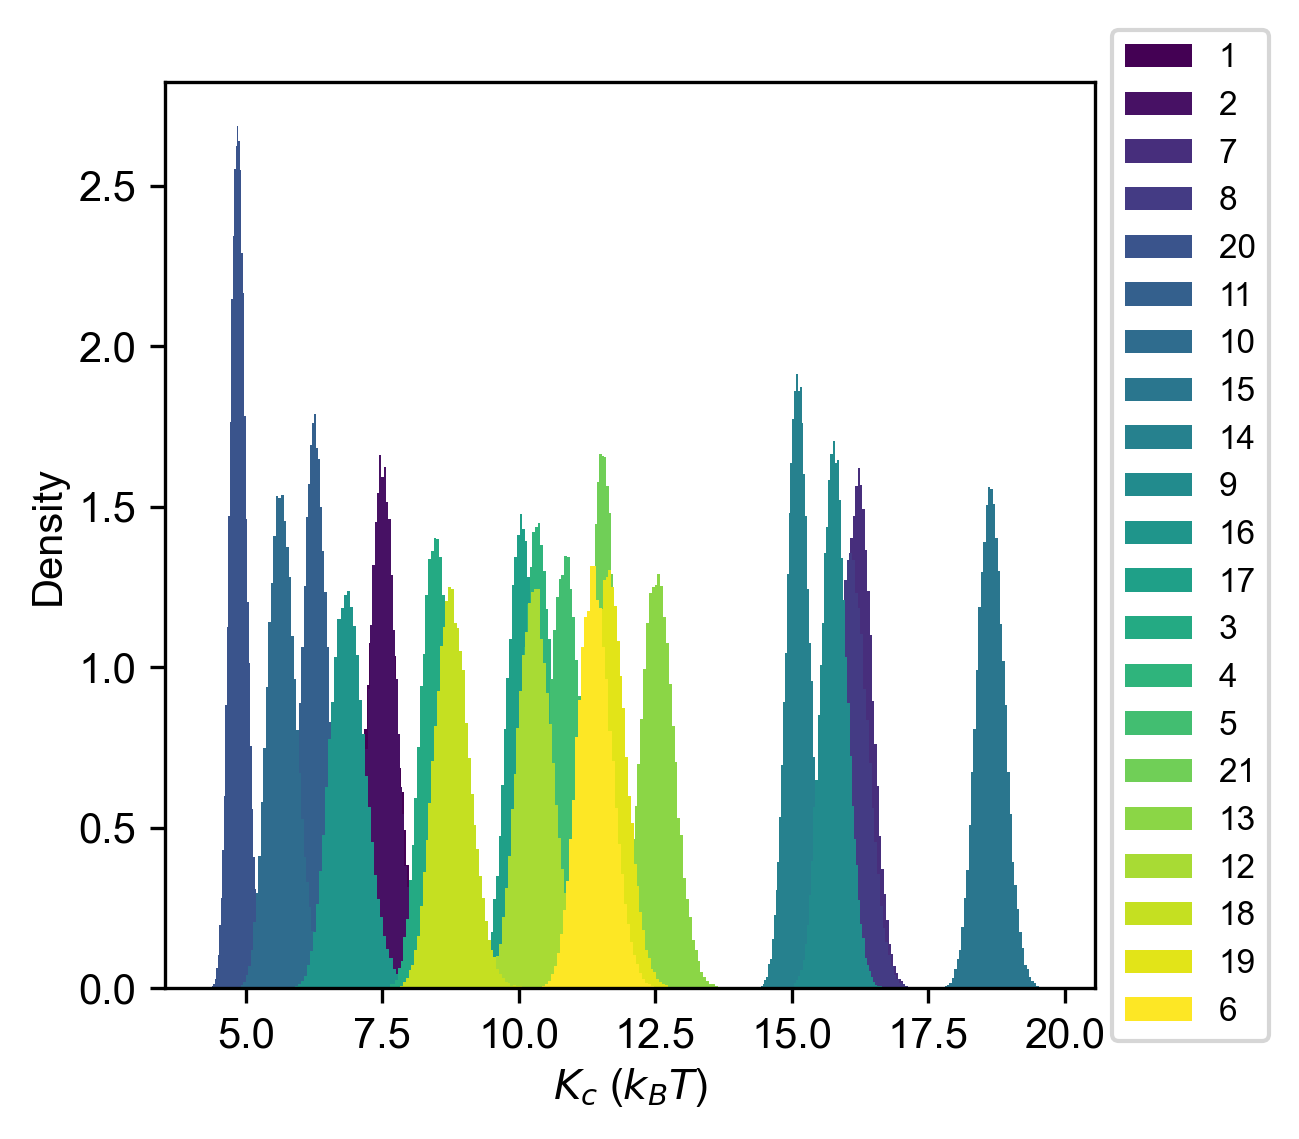

1 [7.518635663879712, 0.28700089753564867]
2 [7.522952733844585, 0.24569027914564287]
3 [8.899505257638213, 0.38588372103032503]
4 [16.235210943756233, 0.2542837839566556]
5 [16.098761802981, 0.2942701417300179]
6 [16.342300570941855, 0.28565909813525625]
7 [4.861000933751257, 0.14684335460547043]
8 [6.28009254912566, 0.2289783173225793]
9 [5.668780482578886, 0.2603803711139715]
10 [18.644686848778015, 0.2578054452441868]
11 [15.118052529687164, 0.20907242598454356]
12 [15.779157654523118, 0.23933822379376515]
13 [6.885615652155114, 0.32473493696291217]
14 [10.064032492792265, 0.2728175538191452]
15 [8.496766134292521, 0.2857300521779575]
16 [10.361760263397835, 0.2769151988373418]
17 [10.864030250872831, 0.2974783611855152]
18 [11.947171663647728, 0.2944560165427397]
19 [11.550992685817052, 0.2366106154774084]
20 [12.550411099188745, 0.30658204947101275]
21 [10.310540076844749, 0.3242008343981848]
22 [8.787368559374793, 0.3250205248824384]
23 [11.660624810607384, 0.3112794217029143]
2

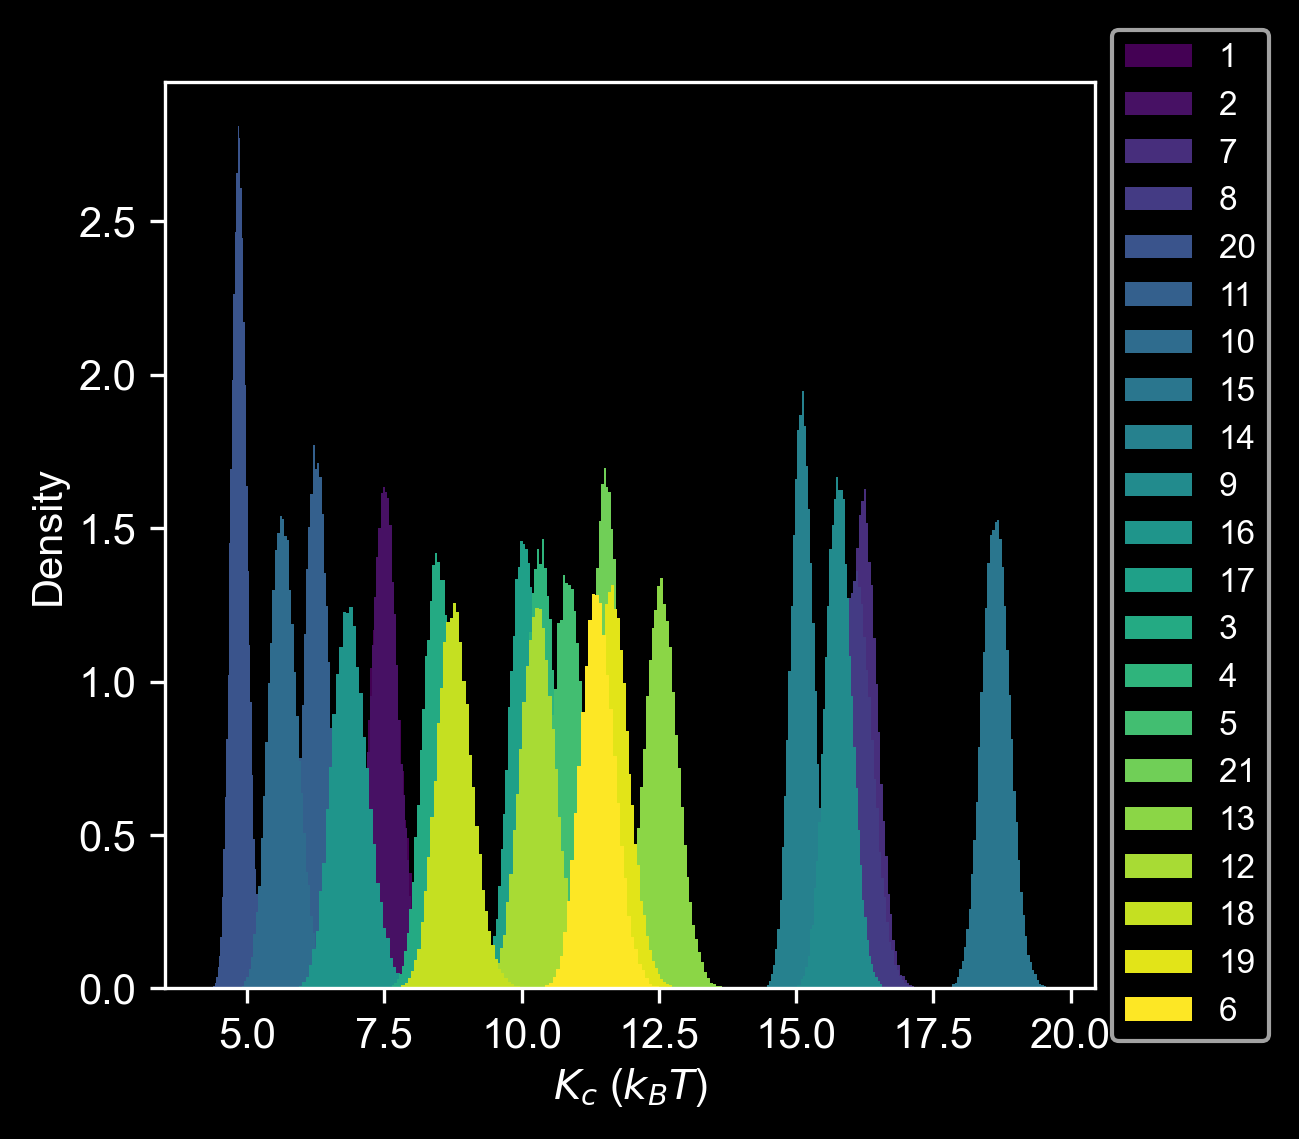

In [14]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


cmap = mpl.cm.get_cmap("viridis")
c = cmap(np.linspace(0, 1, len(util.simulations)))

kc_mean_std = {}


for style, style_ext in plot_styles:
    with plt.style.context(style):
        # Bootstrap values
        fig, ax = plt.subplots(1, 1, figsize=(5, 4))
        for i, sim in enumerate(util.simulations):
            f_rvs = []

            # Construct random Gaussian processe for each wavenumber
            for q in range(corrected_mean_sem[sim].shape[1]):
                # print(corrected_mean_sem[sim][0, i], corrected_mean_sem[sim][1][i])
                r = stats.norm(
                    loc=corrected_mean_sem[sim][0, q],
                    scale=corrected_mean_sem[sim][1][q],
                )
                f_rvs.append(r.rvs)
            # Run parametric bootstrap with random proceses
            boot = util.parametric_bootstrap(f_rvs, n_samples=50000)

            # Fit kcs to bootstrap samples
            kcs = 1.0 / np.mean(boot, axis=0)
            kc_mean_std[sim] = [np.mean(kcs), np.std(kcs)]

            print(sim, kc_mean_std[sim])

            if util.sim_to_final_index[sim] < 0:
                continue

            # Plot distribution of kce)
            ax.hist(
                kcs,
                bins=50,
                density=True,
                color=c[i],
                label=f"{util.sim_to_final_index[sim]}",
            )

        ax.set_xlabel(r"$K_c$ ($k_BT$)")
        ax.set_ylabel("Density")

        # Shrink current axis by 20%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # ax.set_xlim([0,25])

        # Put a legend to the right of the current axis
        ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

        save_fig(fig, curr_fig_path / f"kc_distributions{style_ext}")

        if show_figs:
            plt.show()
        fig.clear()
        plt.close(fig)


np.save("kc_mean_std.npy", kc_mean_std)


In [15]:
kc_mean_std = np.load("kc_mean_std.npy", allow_pickle=True).item()


In [16]:
show_figs = False
curr_fig_path = Path("Figures/height_spectra_kc")
curr_fig_path.mkdir(parents=True, exist_ok=True)

# # Discard first X% for all trajectories
discard = 10
max_q = 100

for i, sim in enumerate(util.simulations):
    low_q_data = qfour_spectra[sim][:, 0:max_q]
    # low_q_data = spectra[sim][1][:, 0:max_q]

    _, remainder = np.split(low_q_data, [int(discard / 100 * len(low_q_data))])

    # Convert to nm^-1
    q = spectra[sim][0][0:max_q] * 10
    mask = q < kc_low_q * 10

    # q^4*hq
    hq_mean = np.mean(remainder, axis=0)
    hq_std = np.std(remainder, axis=0)

    for style, style_ext in plot_styles:
        with plt.style.context(style):
            if style_ext:
                ecolor='white'
            else:
                ecolor='black'
            fig, ax = plt.subplots(1, 1, figsize=(5, 4))
            ax.errorbar(
                q[mask],
                hq_mean[mask],
                yerr=hq_std[mask],
                fmt=".",
                markersize=3,
                elinewidth=THIN_LINE,
                ecolor="lightgray",
            )

            ax.errorbar(
                q[~mask],
                hq_mean[~mask],
                yerr=hq_std[~mask],
                color="dimgray",
                fmt=".",
                markersize=3,
                elinewidth=THIN_LINE,
                ecolor="lightgray",
            )

            ax.axhline(1 / kc_mean_std[sim][0], color="r")
            # ax.axvline(kc_low_q, color="k", linewidth=0.5, linestyle=":")

            ax.text(
                0.05,
                0.7,
                f"$K_c$ = {kc_mean_std[sim][0]:.1f} $\pm$ {kc_mean_std[sim][1]:.1f} $k_BT$",
                color="r",
                transform=ax.transAxes,
            )

            # ax.set_xlim(5e-2, 5)
            ax.set_ylim(0.0, 0.45)
            ax.set_xscale("log")

            ax.set_ylabel(r"$q^4 \times \mathrm{intensity}$ (nm$^2$)")
            ax.set_xlabel(r"$q$ (nm$^{-1}$)")

            ax.set_title(
                f"System {util.sim_to_final_index[sim]}: {util.system_names[sim]}"
            )
            fig.set_tight_layout(True)

            save_fig(
                fig,
                curr_fig_path
                / f"{util.sim_to_final_index[sim]}_height_spectra_kc{style_ext}",
            )

            if show_figs:
                plt.show()

            fig.clear()
            plt.close(fig)


In [17]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys

    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


pal = sns.color_palette("colorblind")
bar_props = [
    (1, 1, None),
    (3, 1, None),
    (2, 1.1, None),
    (2, 0.95, "///"),
]


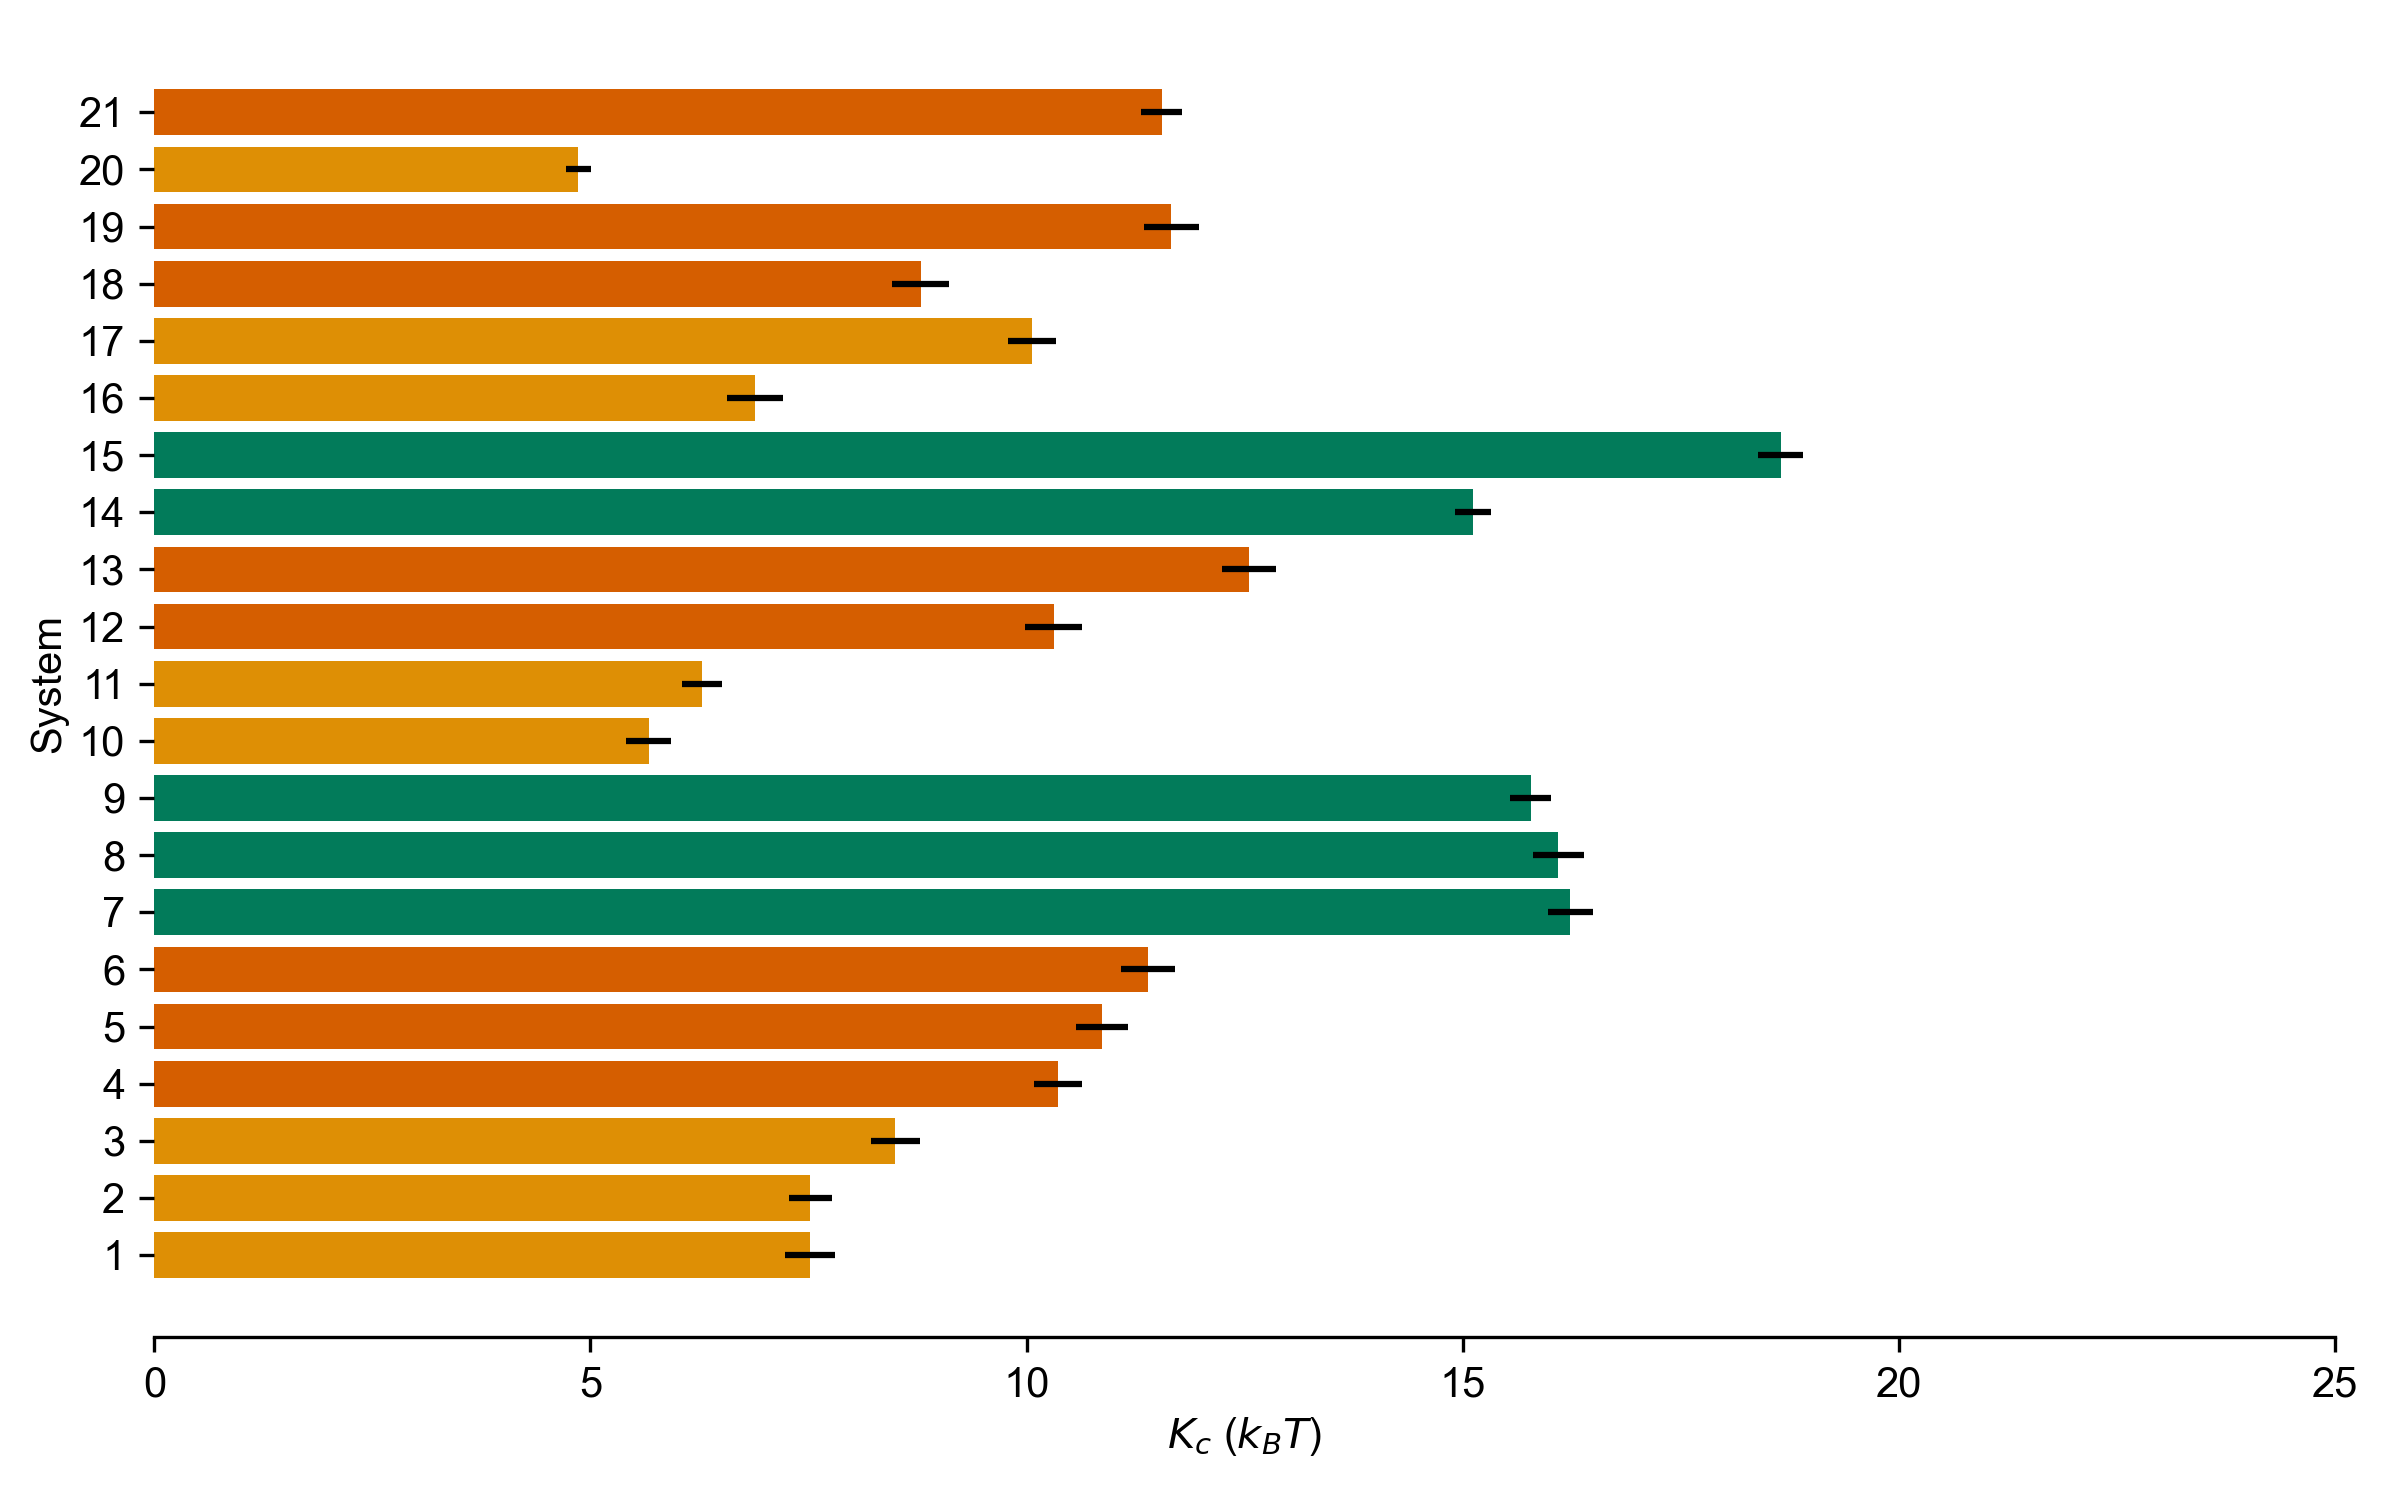

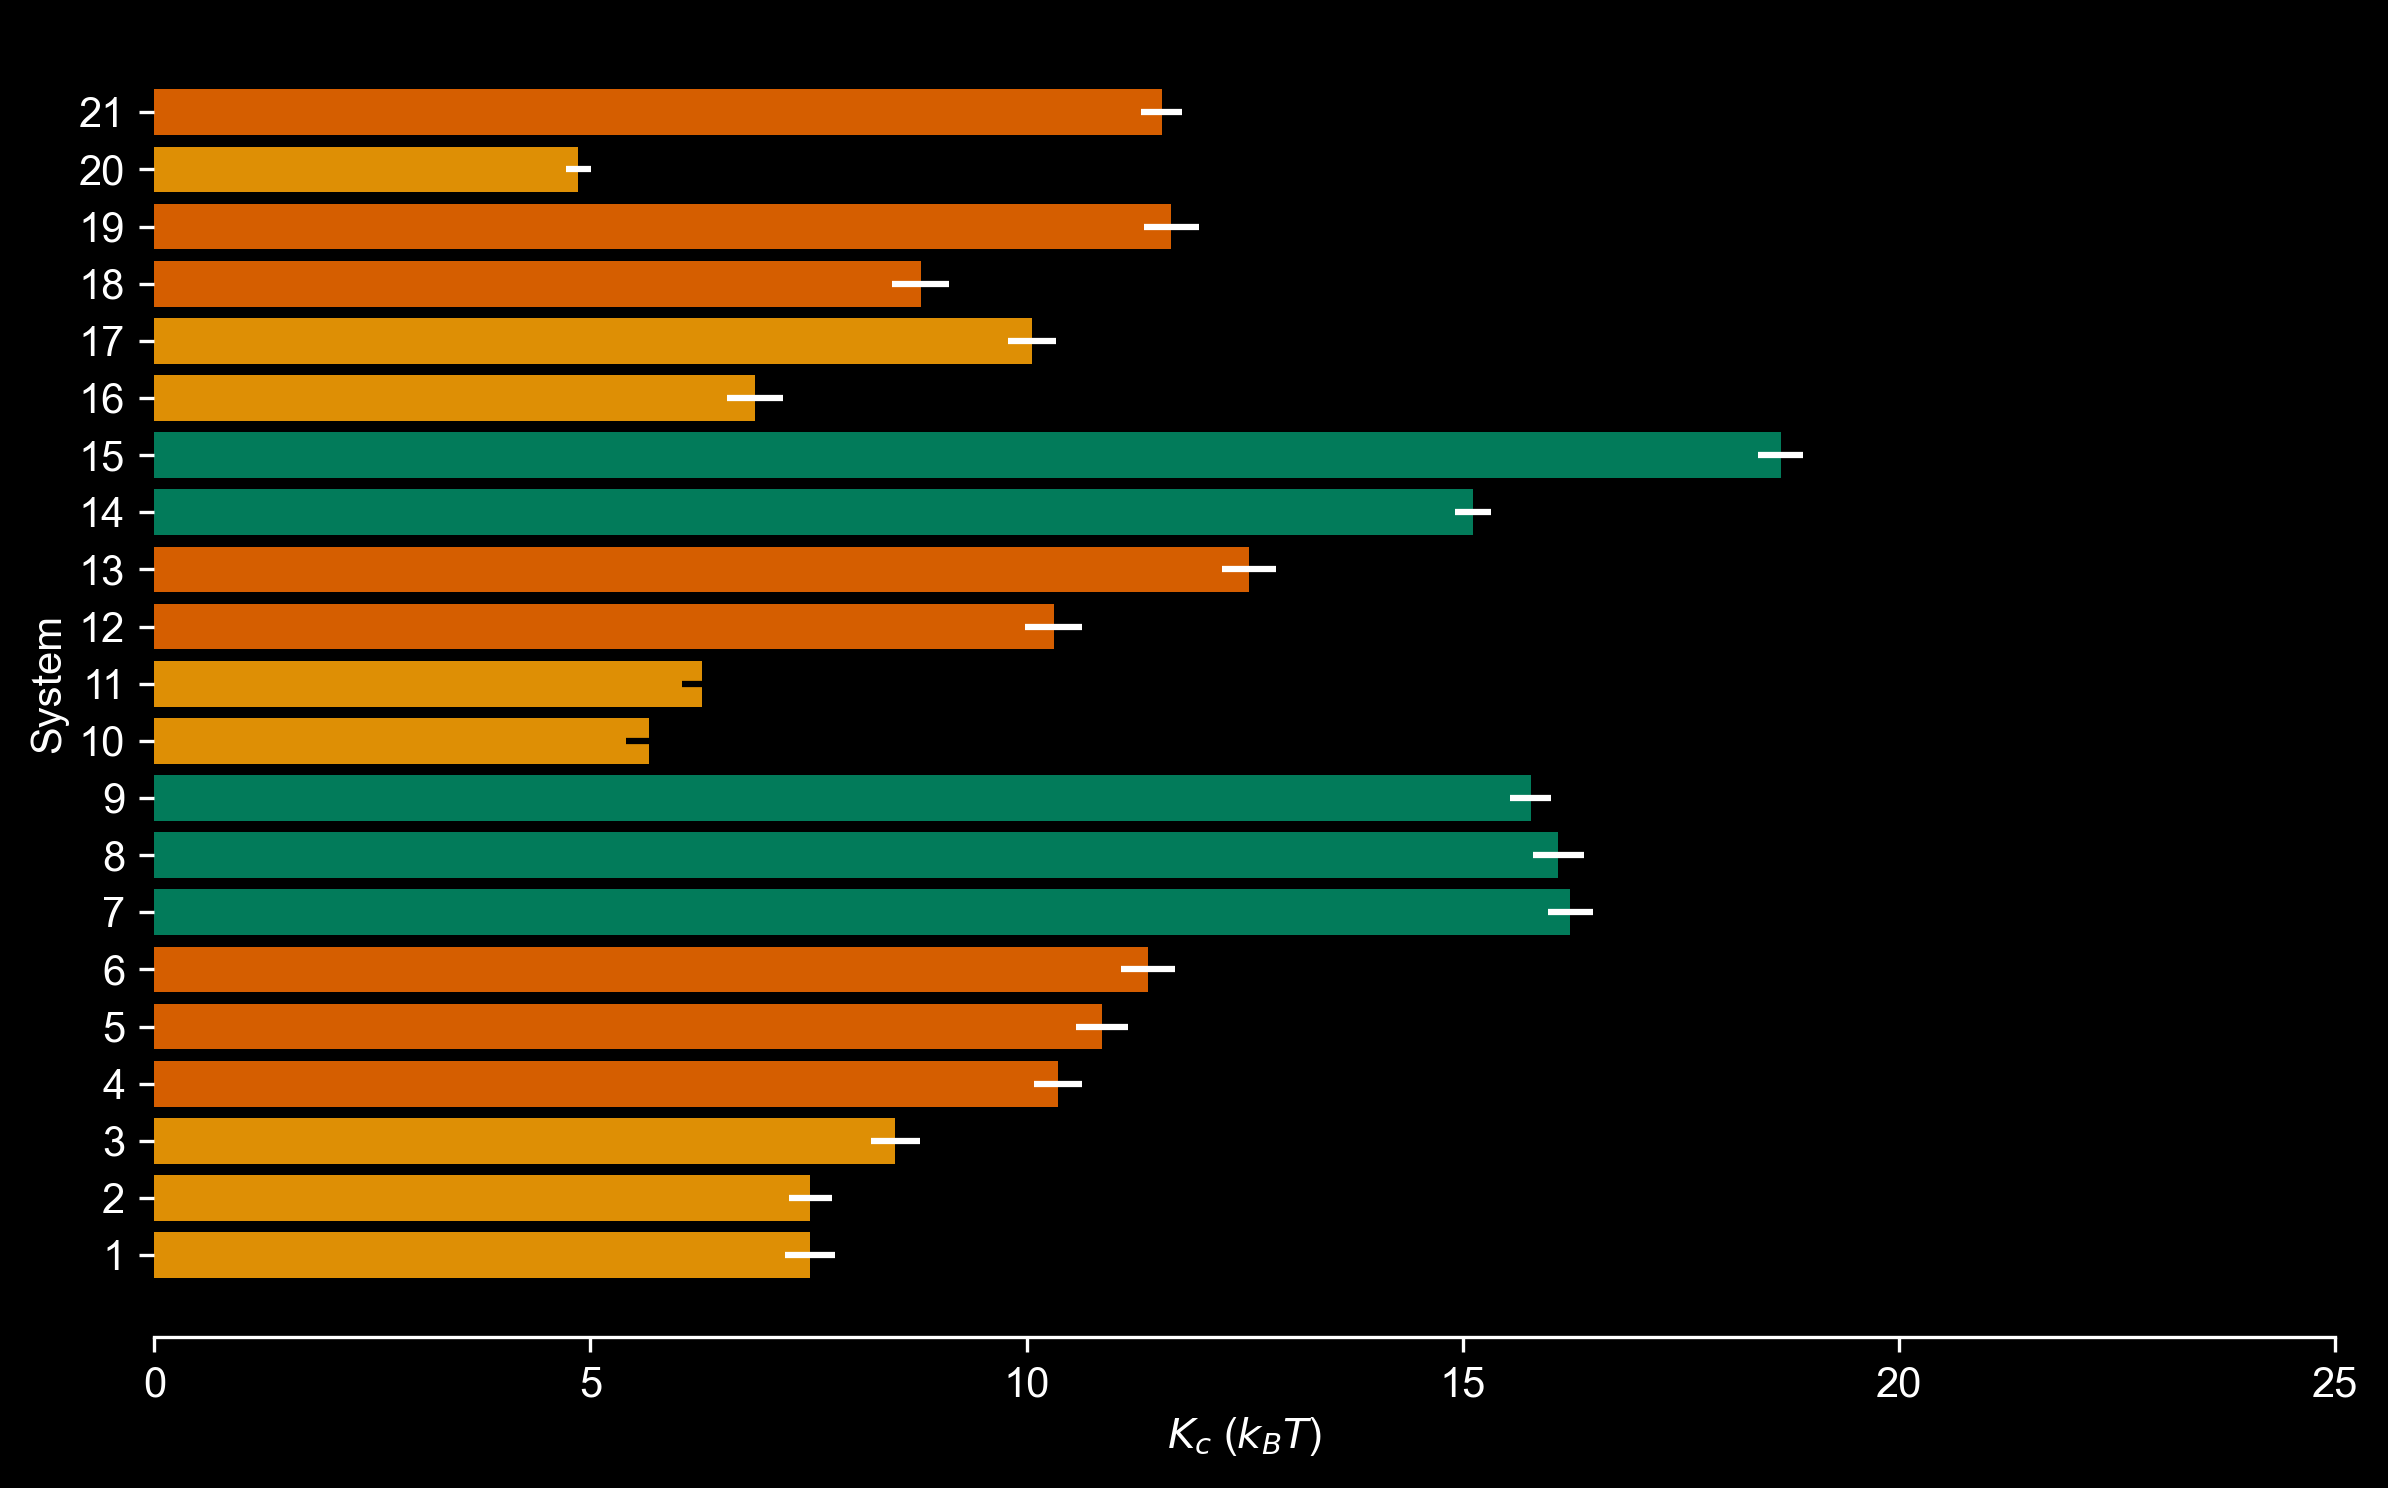

In [18]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))

        for i in range(1, 4):
            ax.barh(
                str(i),
                kc_mean_std[util.remapping_dict[i]][0],
                xerr=kc_mean_std[util.remapping_dict[i]][1],
                color=pal[1],
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(4, 7):
            ax.barh(
                str(i),
                kc_mean_std[util.remapping_dict[i]][0],
                xerr=kc_mean_std[util.remapping_dict[i]][1],
                color=pal[3],
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(7, 10):
            ax.barh(
                str(i),
                kc_mean_std[util.remapping_dict[i]][0],
                xerr=kc_mean_std[util.remapping_dict[i]][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(10, 12):
            ax.barh(
                str(i),
                kc_mean_std[util.remapping_dict[i]][0],
                xerr=kc_mean_std[util.remapping_dict[i]][1],
                color=pal[1],
                height=0.8,
            )

        for i in range(12, 14):
            ax.barh(
                str(i),
                kc_mean_std[util.remapping_dict[i]][0],
                xerr=kc_mean_std[util.remapping_dict[i]][1],
                color=pal[3],
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(14, 16):
            ax.barh(
                str(i),
                kc_mean_std[util.remapping_dict[i]][0],
                xerr=kc_mean_std[util.remapping_dict[i]][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(16, 18):
            ax.barh(
                str(i),
                kc_mean_std[util.remapping_dict[i]][0],
                xerr=kc_mean_std[util.remapping_dict[i]][1],
                color=pal[1],
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(18, 20):
            ax.barh(
                str(i),
                kc_mean_std[util.remapping_dict[i]][0],
                xerr=kc_mean_std[util.remapping_dict[i]][1],
                color=pal[3],
                ecolor=ecolor,
                height=0.8,
            )

        ax.barh(
            "20",
            kc_mean_std[util.remapping_dict[20]][0],
            xerr=kc_mean_std[util.remapping_dict[20]][1],
            color=pal[1],
            ecolor=ecolor,
            height=0.8,
        )

        ax.barh(
            "21",
            kc_mean_std[util.remapping_dict[21]][0],
            xerr=kc_mean_std[util.remapping_dict[21]][1],
            color=pal[3],
            ecolor=ecolor,
            height=0.8,
        )

        # ax.axhline(2.5, color="k")
        # ax.axhline(5.5, color="k")
        # ax.axhline(8.5, color="k")
        # ax.axhline(14.5, color="k")
        # ax.axhline(18.5, color="k")

        ax.set_xlabel(r"$K_c$ ($k_BT$)")
        ax.set_ylabel(r"System")

        ax.set_xlim(0, 25)

        # ax.set_xticklabels(
        #     ax.get_xticks(),
        # )

        # x_ticks_labels = [f"{sim}" for sim in range(1,22)]

        # Set number of ticks for x-axis
        # ax.set_xticks(range(21))
        # Set ticks labels for x-axis
        # ax.set_xticklabels(x_ticks_labels)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

        fig.tight_layout()

        save_fig(fig, curr_fig_path / f"estimated_kcs{style_ext}")

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


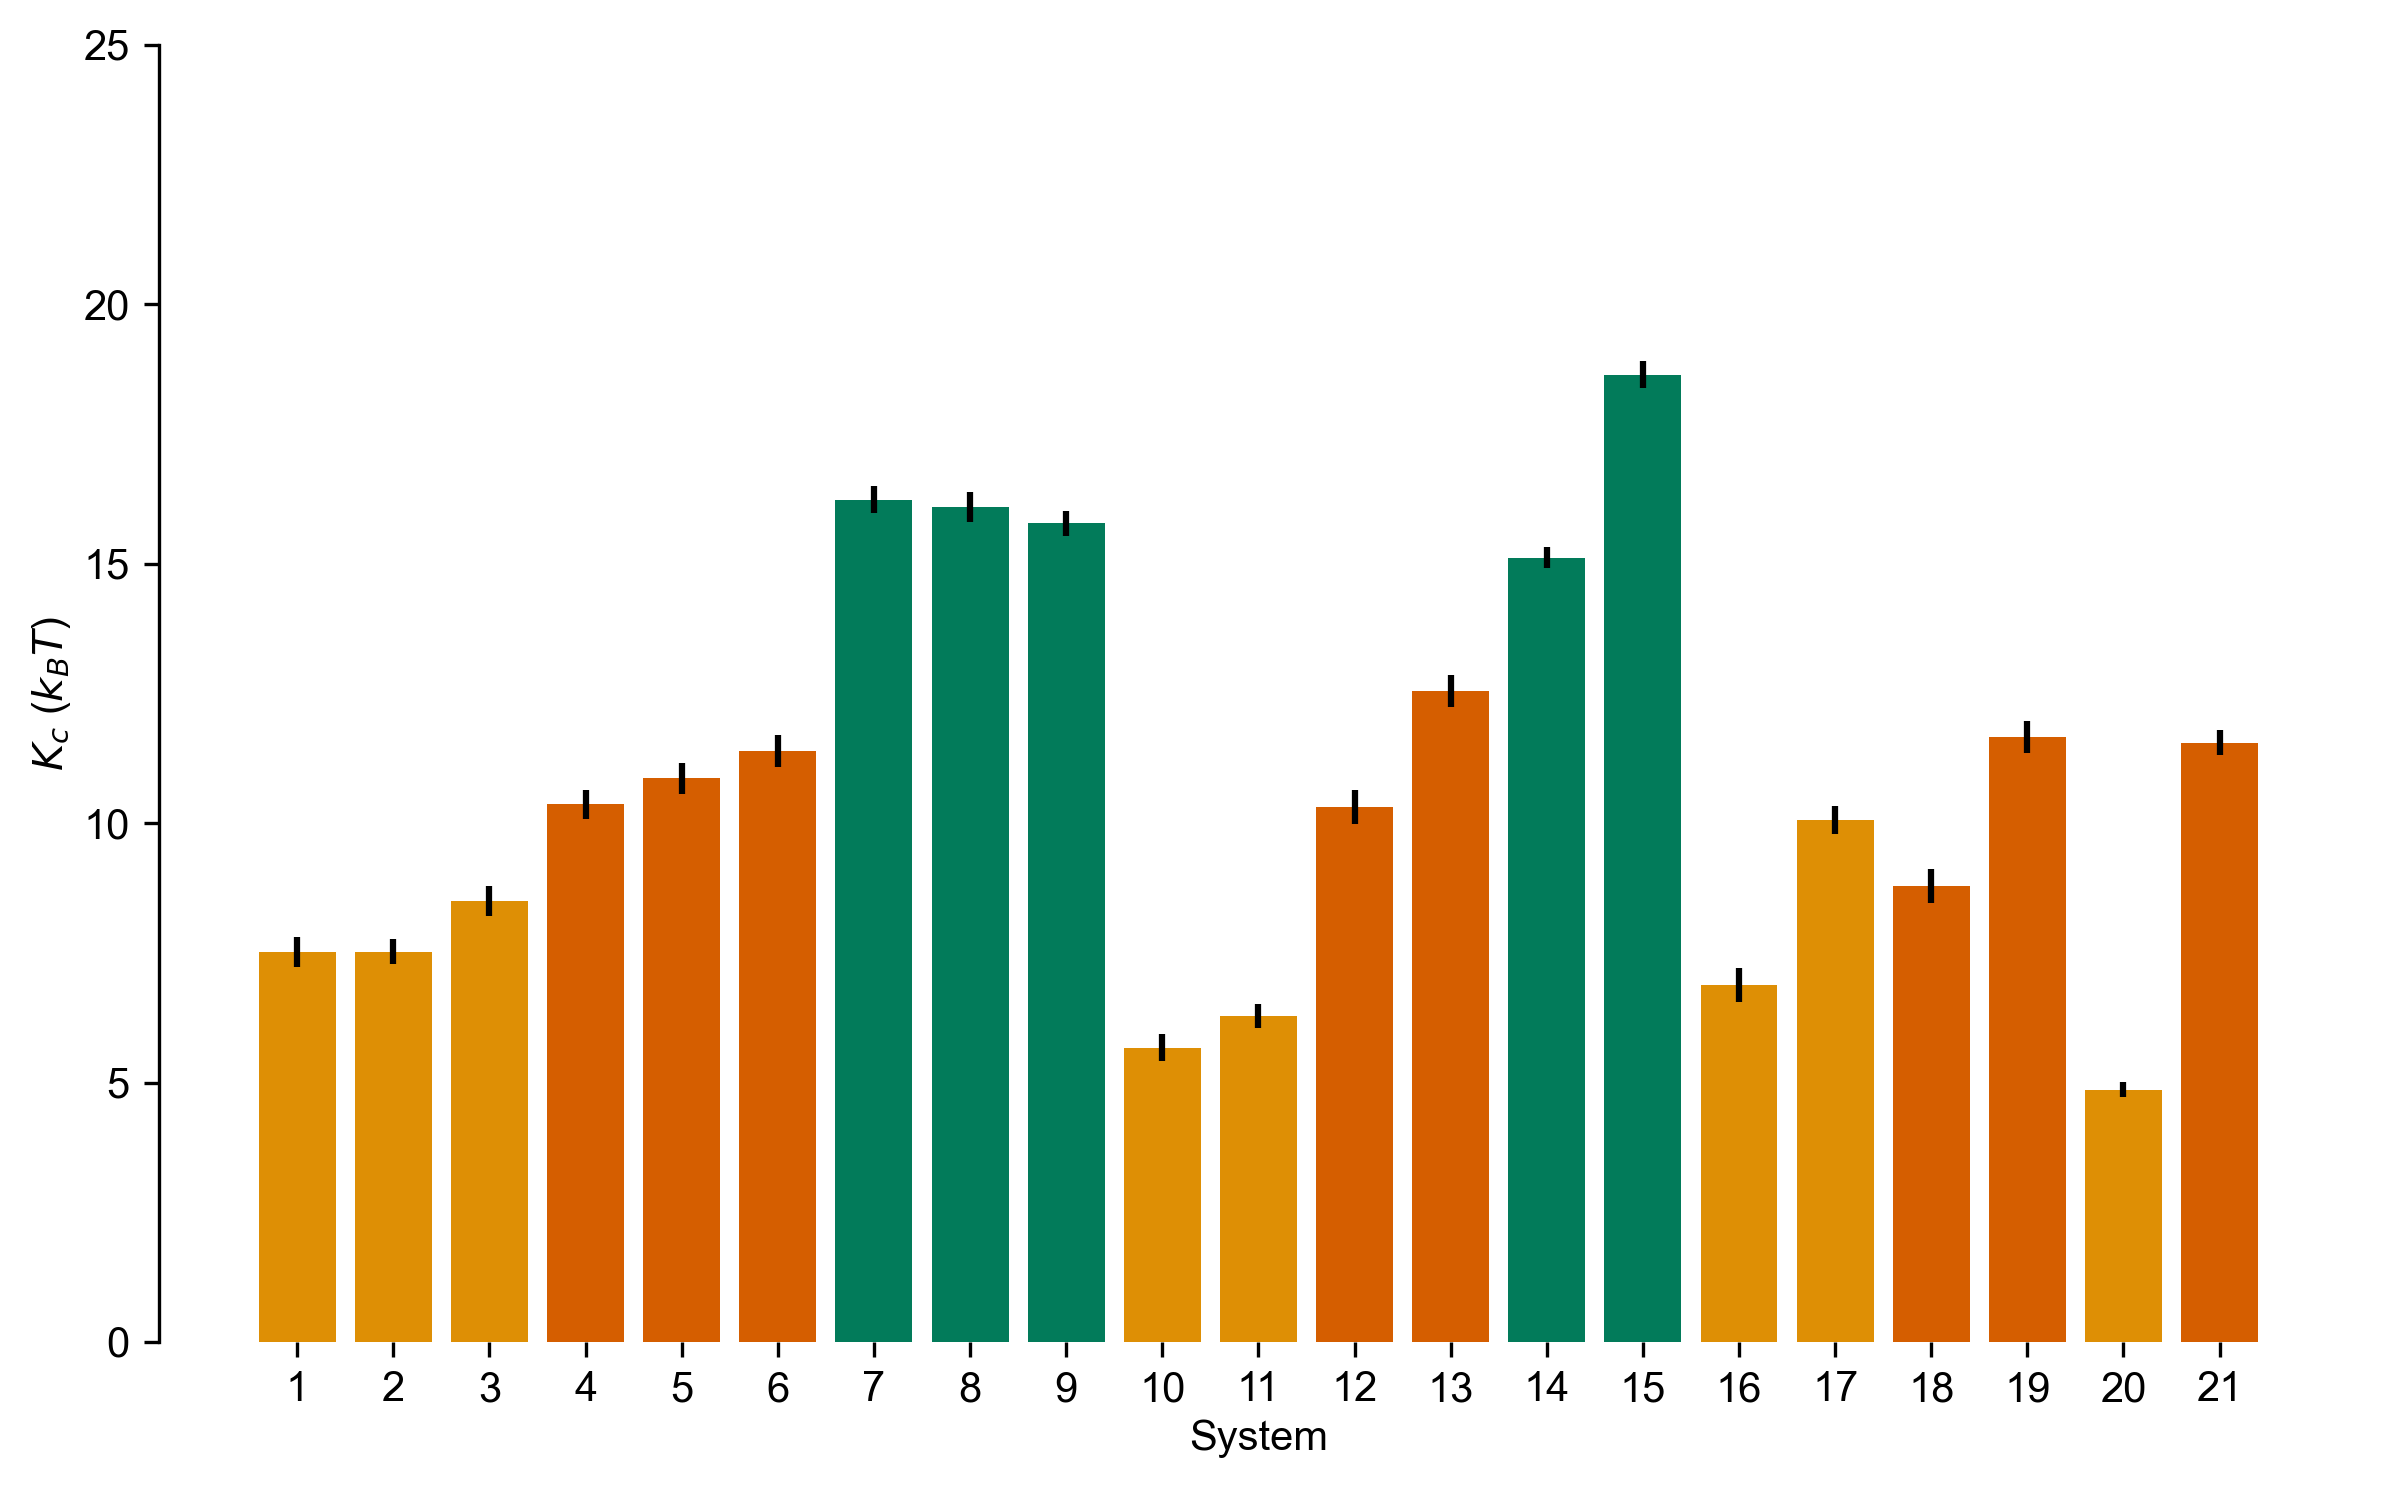

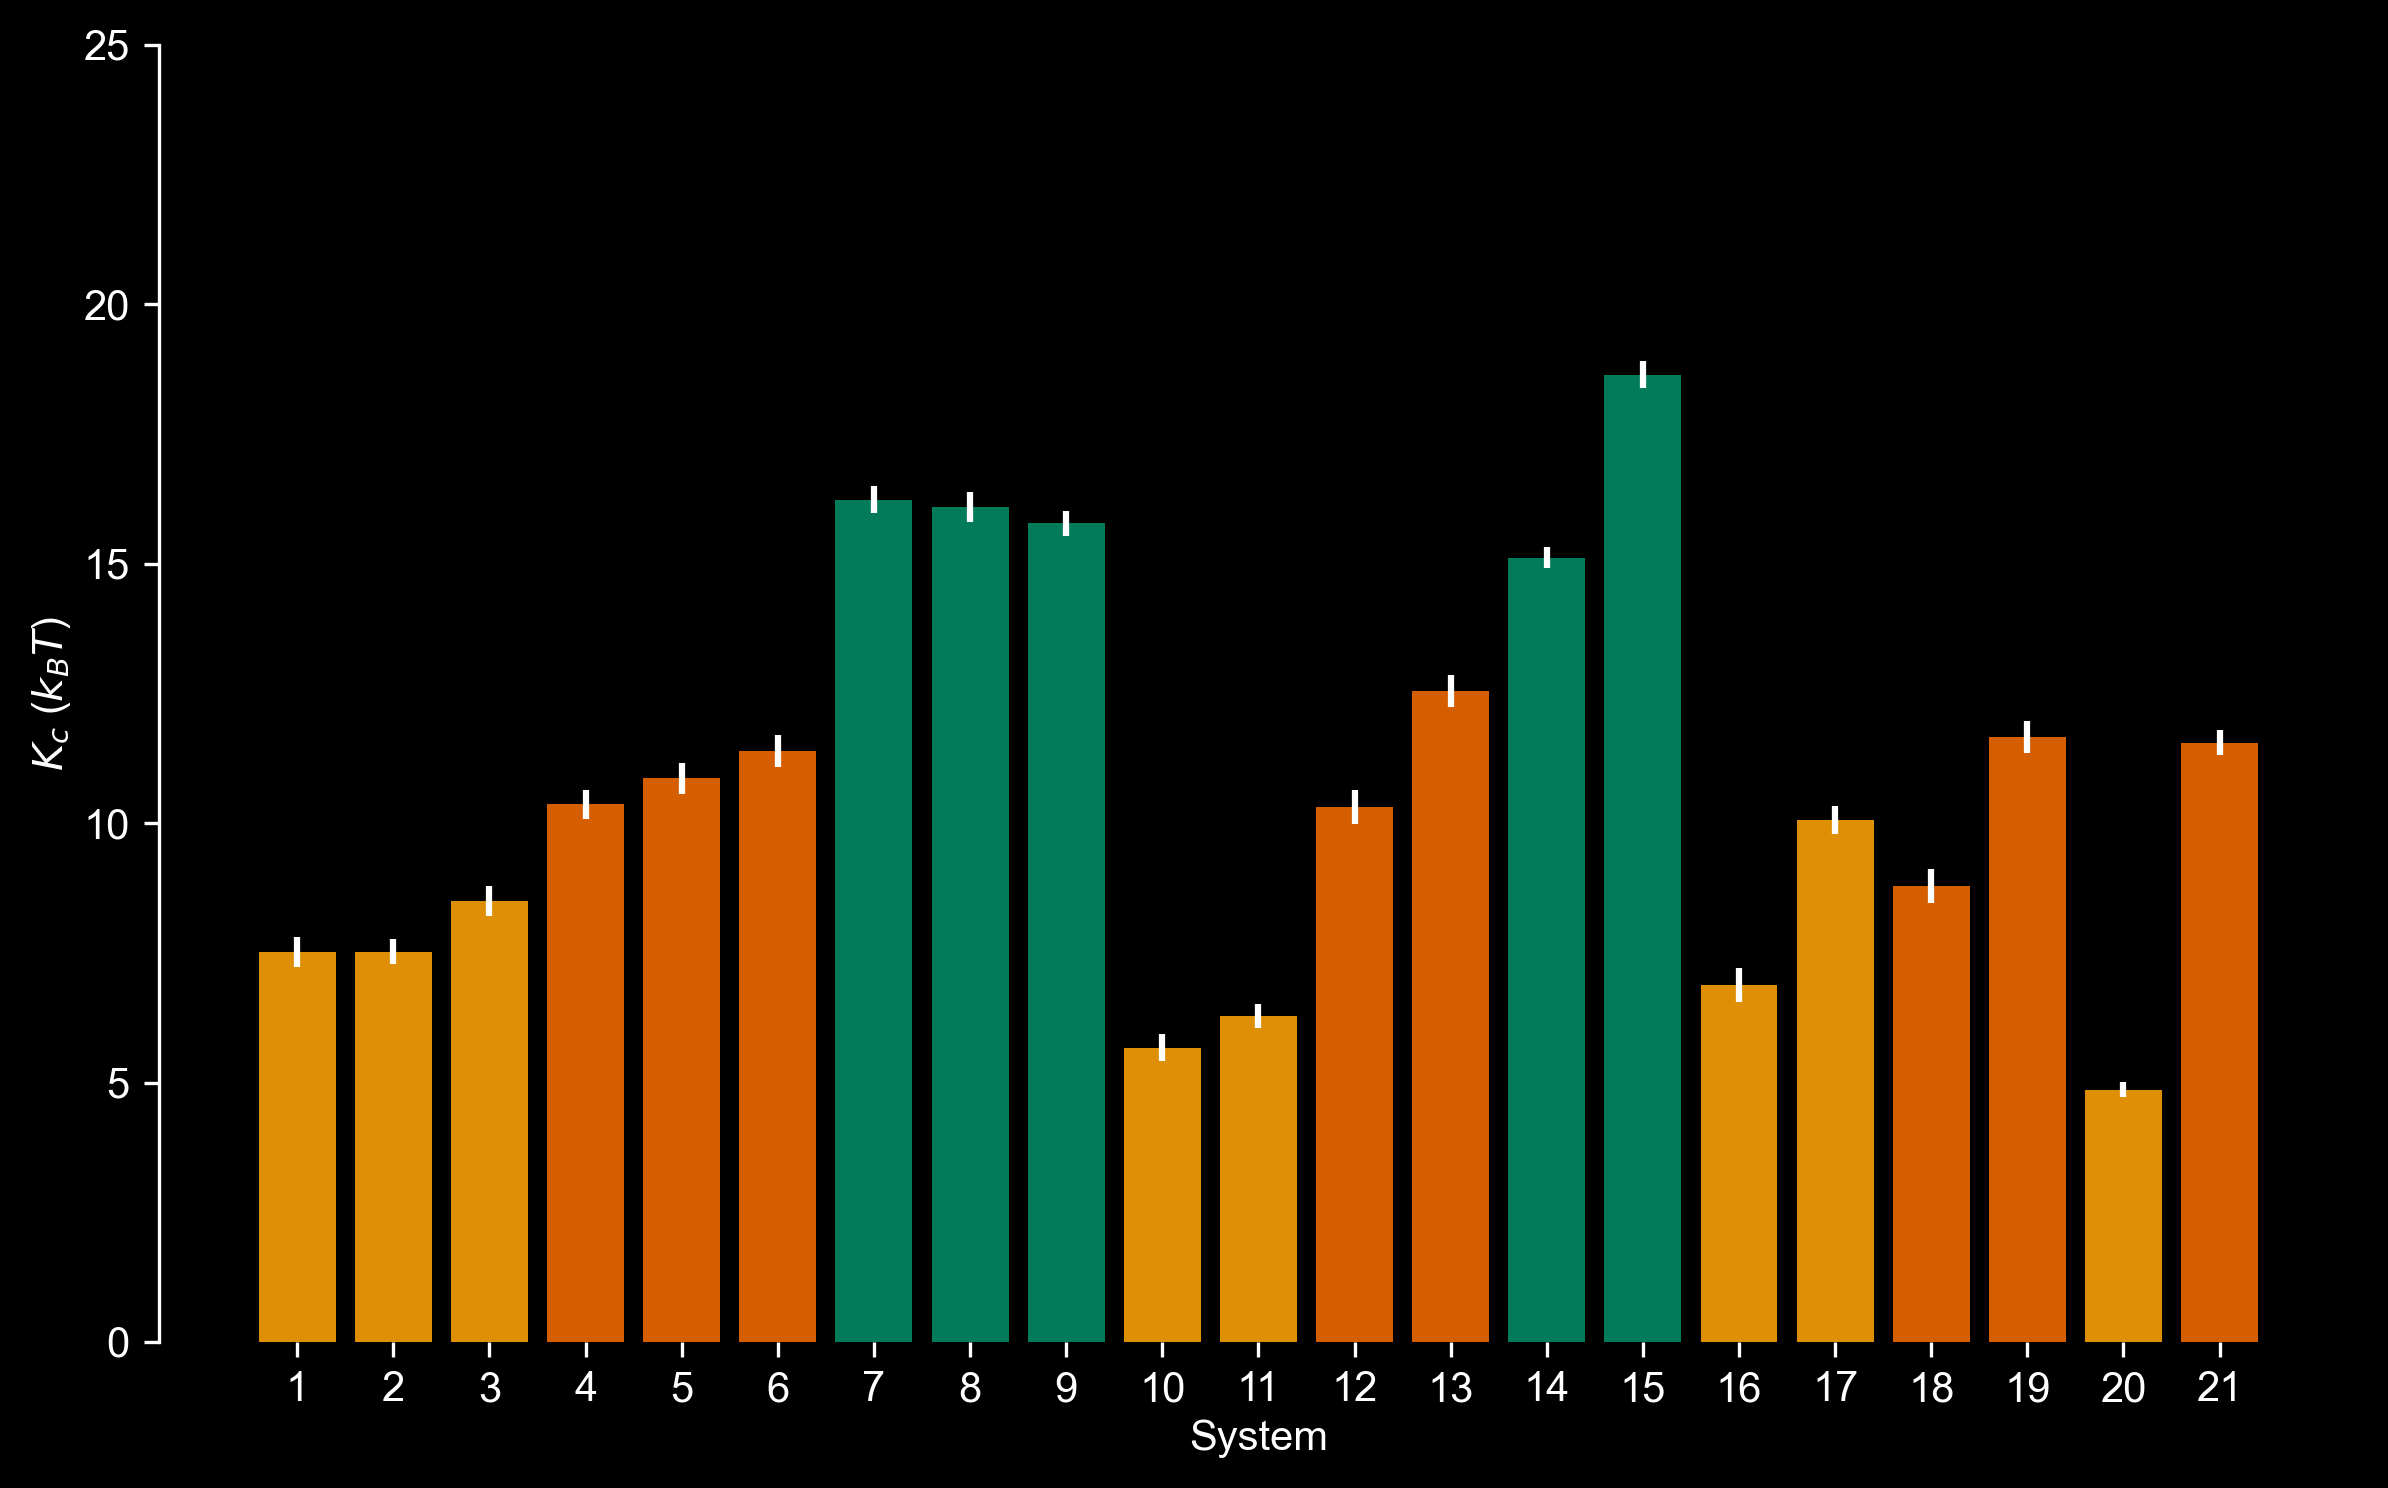

In [19]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor='white'
        else:
            ecolor='black'
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))

        for i in range(1, 4):
            ax.bar(
                str(i),
                kc_mean_std[util.remapping_dict[i]][0],
                yerr=kc_mean_std[util.remapping_dict[i]][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(4, 7):
            ax.bar(
                str(i),
                kc_mean_std[util.remapping_dict[i]][0],
                yerr=kc_mean_std[util.remapping_dict[i]][1],
                color=pal[3],
                ecolor=ecolor,
            )

        for i in range(7, 10):
            ax.bar(
                str(i),
                kc_mean_std[util.remapping_dict[i]][0],
                yerr=kc_mean_std[util.remapping_dict[i]][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
            )

        for i in range(10, 12):
            ax.bar(
                str(i),
                kc_mean_std[util.remapping_dict[i]][0],
                yerr=kc_mean_std[util.remapping_dict[i]][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(12, 14):
            ax.bar(
                str(i),
                kc_mean_std[util.remapping_dict[i]][0],
                yerr=kc_mean_std[util.remapping_dict[i]][1],
                color=pal[3],
                ecolor=ecolor,
            )

        for i in range(14, 16):
            ax.bar(
                str(i),
                kc_mean_std[util.remapping_dict[i]][0],
                yerr=kc_mean_std[util.remapping_dict[i]][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
            )

        for i in range(16, 18):
            ax.bar(
                str(i),
                kc_mean_std[util.remapping_dict[i]][0],
                yerr=kc_mean_std[util.remapping_dict[i]][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(18, 20):
            ax.bar(
                str(i),
                kc_mean_std[util.remapping_dict[i]][0],
                yerr=kc_mean_std[util.remapping_dict[i]][1],
                color=pal[3],
                ecolor=ecolor,
            )

        ax.bar(
            "20",
            kc_mean_std[util.remapping_dict[20]][0],
            yerr=kc_mean_std[util.remapping_dict[20]][1],
            color=pal[1],
            ecolor=ecolor,
        )

        ax.bar(
            "21",
            kc_mean_std[util.remapping_dict[21]][0],
            yerr=kc_mean_std[util.remapping_dict[21]][1],
            color=pal[3],
            ecolor=ecolor,
        )

        # ax.axhline(2.5, color="k")
        # ax.axhline(5.5, color="k")
        # ax.axhline(8.5, color="k")
        # ax.axhline(14.5, color="k")
        # ax.axhline(18.5, color="k")

        ax.set_ylabel(r"$K_c$ ($k_BT$)")
        ax.set_xlabel(r"System")

        ax.set_ylim(0, 25)

        # ax.set_xticklabels(
        #     ax.get_xticks(),
        # )

        # x_ticks_labels = [f"{sim}" for sim in range(1,22)]

        # Set number of ticks for x-axis
        # ax.set_xticks(range(21))
        # Set ticks labels for x-axis
        # ax.set_xticklabels(x_ticks_labels)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        # ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

        fig.tight_layout()

        save_fig(fig, curr_fig_path / f"estimated_kcs_vertical{style_ext}")

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


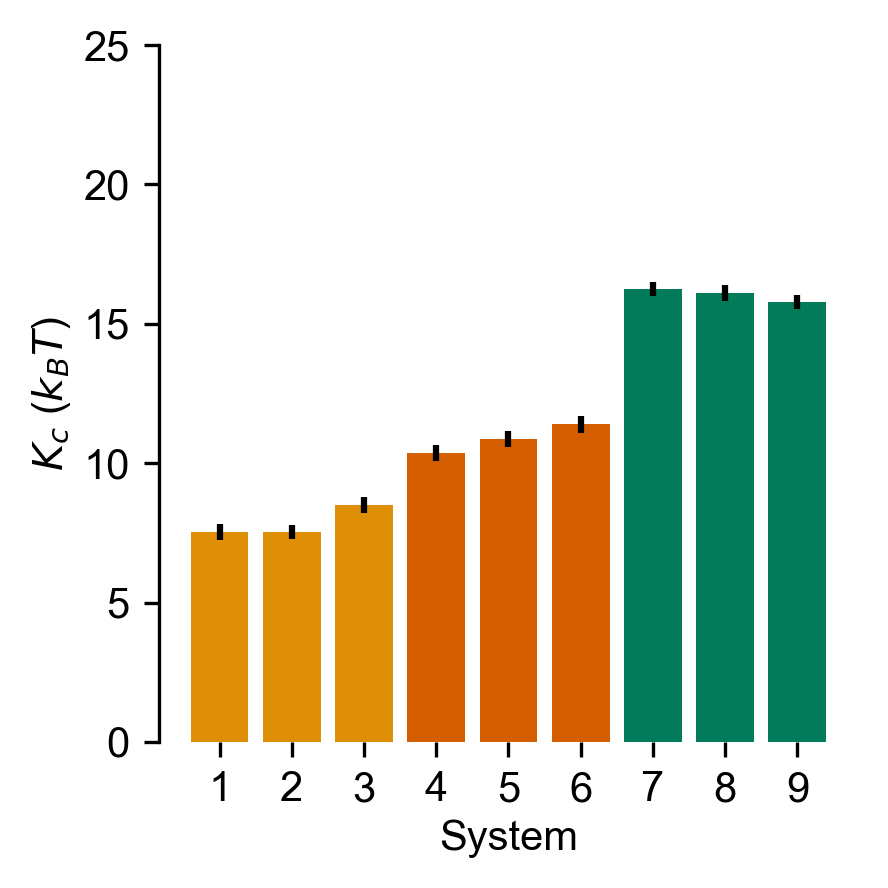

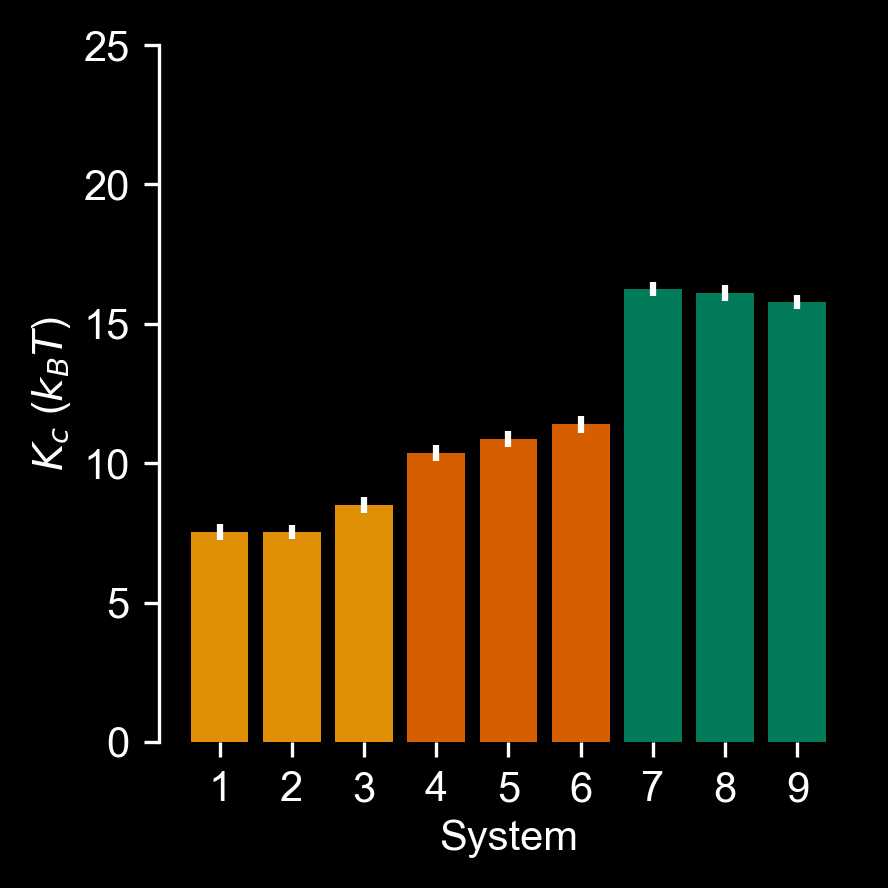

In [20]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor='white'
        else:
            ecolor='black'
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))

        for i in range(1, 4):
            ax.bar(
                str(i),
                kc_mean_std[util.remapping_dict[i]][0],
                yerr=kc_mean_std[util.remapping_dict[i]][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(4, 7):
            ax.bar(
                str(i),
                kc_mean_std[util.remapping_dict[i]][0],
                yerr=kc_mean_std[util.remapping_dict[i]][1],
                color=pal[3],
                ecolor=ecolor,
            )

        for i in range(7, 10):
            ax.bar(
                str(i),
                kc_mean_std[util.remapping_dict[i]][0],
                yerr=kc_mean_std[util.remapping_dict[i]][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
            )

        # for i in range(10, 12):
        #     ax.bar(
        #         str(i),
        #         kc_mean_std[util.remapping_dict[i]][0],
        #         yerr=kc_mean_std[util.remapping_dict[i]][1],
        #         color=pal[1],
        #     )

        # for i in range(12, 14):
        #     ax.bar(
        #         str(i),
        #         kc_mean_std[util.remapping_dict[i]][0],
        #         yerr=kc_mean_std[util.remapping_dict[i]][1],
        #         color=pal[3],
        #     )

        # for i in range(14, 16):
        #     ax.bar(
        #         str(i),
        #         kc_mean_std[util.remapping_dict[i]][0],
        #         yerr=kc_mean_std[util.remapping_dict[i]][1],
        #         color=lighten_color(pal[2], 1.1),
        #     )

        # for i in range(16, 18):
        #     ax.bar(
        #         str(i),
        #         kc_mean_std[util.remapping_dict[i]][0],
        #         yerr=kc_mean_std[util.remapping_dict[i]][1],
        #         color=pal[1],
        #     )

        # for i in range(18, 20):
        #     ax.bar(
        #         str(i),
        #         kc_mean_std[util.remapping_dict[i]][0],
        #         yerr=kc_mean_std[util.remapping_dict[i]][1],
        #         color=pal[3],
        #     )

        # ax.bar(
        #     "20",
        #     kc_mean_std[util.remapping_dict[20]][0],
        #     yerr=kc_mean_std[util.remapping_dict[20]][1],
        #     color=pal[1],
        # )

        # ax.bar(
        #     "21",
        #     kc_mean_std[util.remapping_dict[21]][0],
        #     yerr=kc_mean_std[util.remapping_dict[21]][1],
        #     color=pal[3],
        # )

        # ax.axhline(2.5, color="k")
        # ax.axhline(5.5, color="k")
        # ax.axhline(8.5, color="k")
        # ax.axhline(14.5, color="k")
        # ax.axhline(18.5, color="k")

        ax.set_ylabel(r"$K_c$ ($k_BT$)")
        ax.set_xlabel(r"System")

        ax.set_ylim(0, 25)

        # ax.set_xticklabels(
        #     ax.get_xticks(),
        # )

        # x_ticks_labels = [f"{sim}" for sim in range(1,22)]

        # Set number of ticks for x-axis
        # ax.set_xticks(range(21))
        # Set ticks labels for x-axis
        # ax.set_xticklabels(x_ticks_labels)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        # ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

        fig.tight_layout()

        save_fig(fig, curr_fig_path / f"estimated_kcs1-9{style_ext}")

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


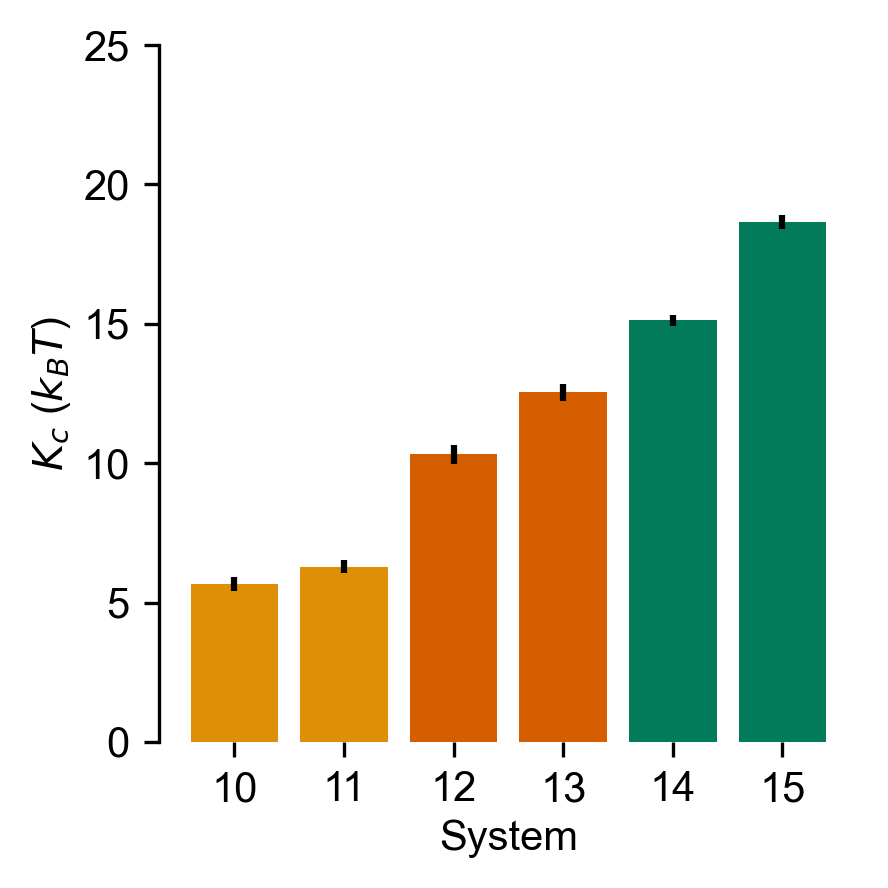

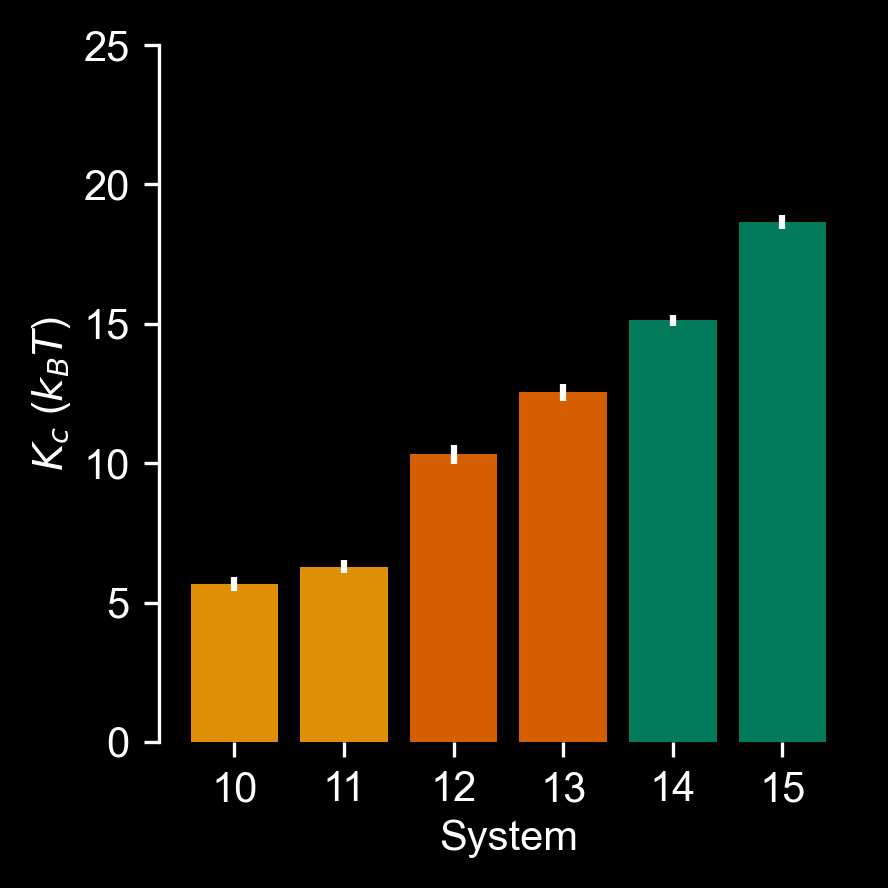

In [21]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor='white'
        else:
            ecolor='black'
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
        # for i in range(1, 4):
        #     ax.bar(
        #         str(i),
        #         kc_mean_std[util.remapping_dict[i]][0],
        #         yerr=kc_mean_std[util.remapping_dict[i]][1],
        #         color=pal[1],
        #     )

        # for i in range(4, 7):
        #     ax.bar(
        #         str(i),
        #         kc_mean_std[util.remapping_dict[i]][0],
        #         yerr=kc_mean_std[util.remapping_dict[i]][1],
        #         color=pal[3],
        #     )

        # for i in range(7, 10):
        #     ax.bar(
        #         str(i),
        #         kc_mean_std[util.remapping_dict[i]][0],
        #         yerr=kc_mean_std[util.remapping_dict[i]][1],
        #         color=lighten_color(pal[2], 1.1),
        #     )

        for i in range(10, 12):
            ax.bar(
                str(i),
                kc_mean_std[util.remapping_dict[i]][0],
                yerr=kc_mean_std[util.remapping_dict[i]][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(12, 14):
            ax.bar(
                str(i),
                kc_mean_std[util.remapping_dict[i]][0],
                yerr=kc_mean_std[util.remapping_dict[i]][1],
                color=pal[3],
                ecolor=ecolor,
            )

        for i in range(14, 16):
            ax.bar(
                str(i),
                kc_mean_std[util.remapping_dict[i]][0],
                yerr=kc_mean_std[util.remapping_dict[i]][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
            )

        # for i in range(16, 18):
        #     ax.bar(
        #         str(i),
        #         kc_mean_std[util.remapping_dict[i]][0],
        #         yerr=kc_mean_std[util.remapping_dict[i]][1],
        #         color=pal[1],
        #     )

        # for i in range(18, 20):
        #     ax.bar(
        #         str(i),
        #         kc_mean_std[util.remapping_dict[i]][0],
        #         yerr=kc_mean_std[util.remapping_dict[i]][1],
        #         color=pal[3],
        #     )

        # ax.bar(
        #     "20",
        #     kc_mean_std[util.remapping_dict[20]][0],
        #     yerr=kc_mean_std[util.remapping_dict[20]][1],
        #     color=pal[1],
        # )

        # ax.bar(
        #     "21",
        #     kc_mean_std[util.remapping_dict[21]][0],
        #     yerr=kc_mean_std[util.remapping_dict[21]][1],
        #     color=pal[3],
        # )

        # ax.axhline(2.5, color="k")
        # ax.axhline(5.5, color="k")
        # ax.axhline(8.5, color="k")
        # ax.axhline(14.5, color="k")
        # ax.axhline(18.5, color="k")

        ax.set_ylabel(r"$K_c$ ($k_BT$)")
        ax.set_xlabel(r"System")

        ax.set_ylim(0, 25)

        # ax.set_xticklabels(
        #     ax.get_xticks(),
        # )

        # x_ticks_labels = [f"{sim}" for sim in range(1,22)]

        # Set number of ticks for x-axis
        # ax.set_xticks(range(21))
        # Set ticks labels for x-axis
        # ax.set_xticklabels(x_ticks_labels)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        # ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

        fig.tight_layout()

        save_fig(fig, curr_fig_path / f"estimated_kcs10-15{style_ext}")

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


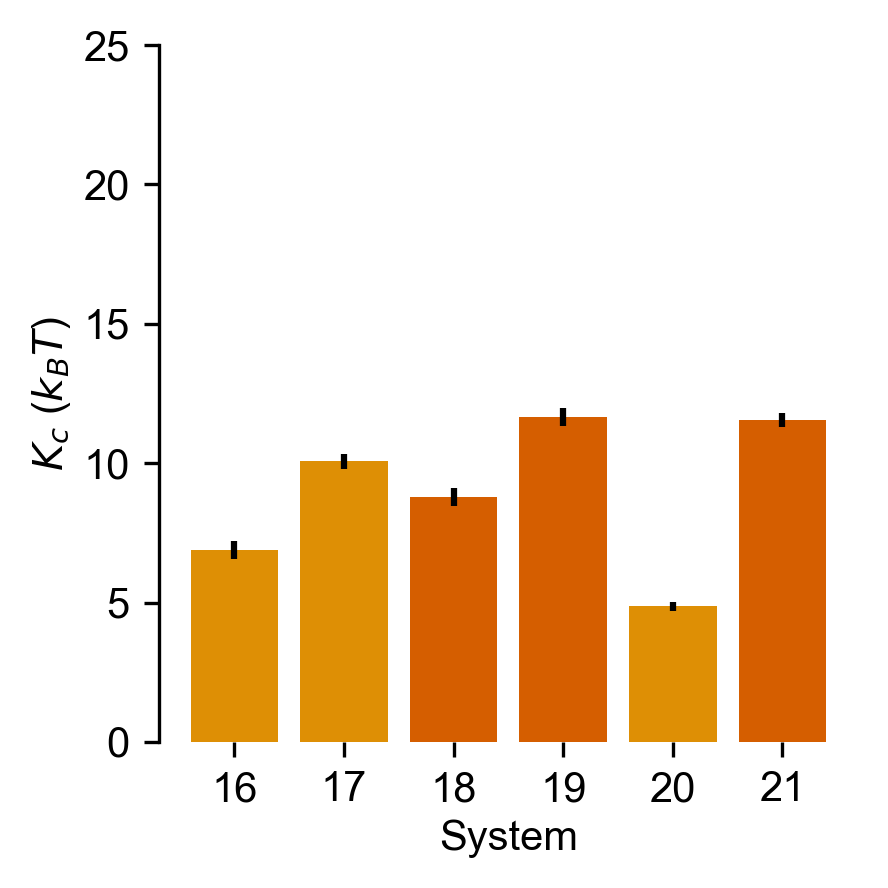

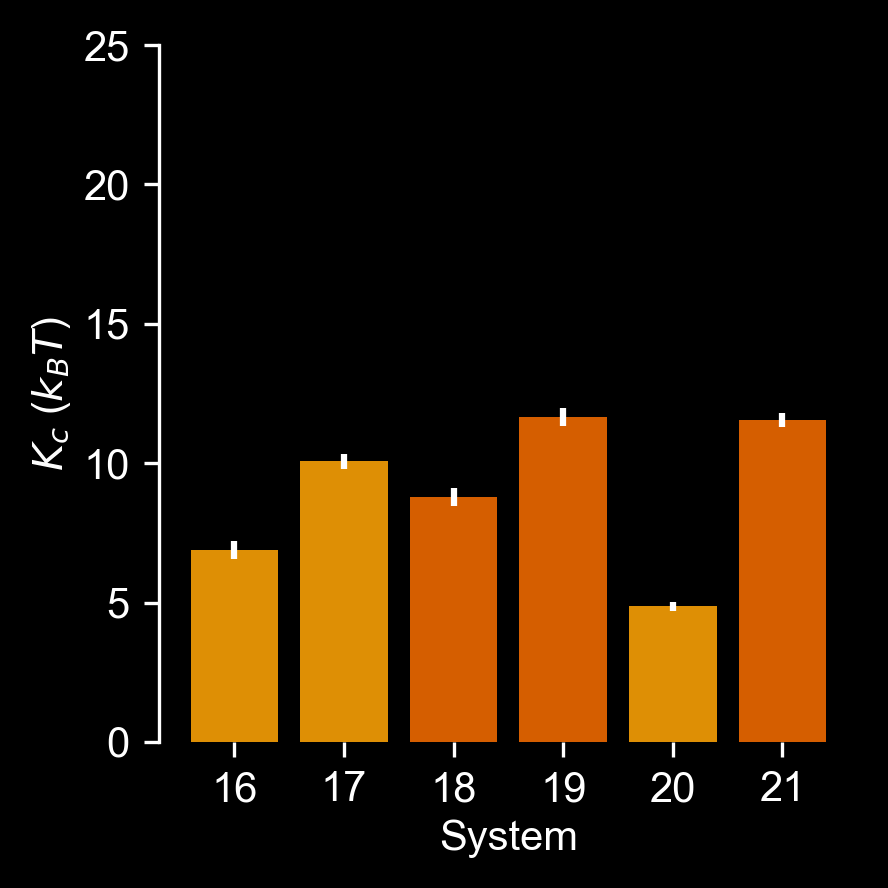

In [22]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor='white'
        else:
            ecolor='black'

        fig, ax = plt.subplots(1, 1, figsize=(3, 3))

        # for i in range(1, 4):
        #     ax.bar(
        #         str(i),
        #         kc_mean_std[util.remapping_dict[i]][0],
        #         yerr=kc_mean_std[util.remapping_dict[i]][1],
        #         color=pal[1],
        #     )

        # for i in range(4, 7):
        #     ax.bar(
        #         str(i),
        #         kc_mean_std[util.remapping_dict[i]][0],
        #         yerr=kc_mean_std[util.remapping_dict[i]][1],
        #         color=pal[3],
        #     )

        # for i in range(7, 10):
        #     ax.bar(
        #         str(i),
        #         kc_mean_std[util.remapping_dict[i]][0],
        #         yerr=kc_mean_std[util.remapping_dict[i]][1],
        #         color=lighten_color(pal[2], 1.1),
        #     )

        # for i in range(10, 12):
        #     ax.bar(
        #         str(i),
        #         kc_mean_std[util.remapping_dict[i]][0],
        #         yerr=kc_mean_std[util.remapping_dict[i]][1],
        #         color=pal[1],
        #     )

        # for i in range(12, 14):
        #     ax.bar(
        #         str(i),
        #         kc_mean_std[util.remapping_dict[i]][0],
        #         yerr=kc_mean_std[util.remapping_dict[i]][1],
        #         color=pal[3],
        #     )

        # for i in range(14, 16):
        #     ax.bar(
        #         str(i),
        #         kc_mean_std[util.remapping_dict[i]][0],
        #         yerr=kc_mean_std[util.remapping_dict[i]][1],
        #         color=lighten_color(pal[2], 1.1),
        #     )

        for i in range(16, 18):
            ax.bar(
                str(i),
                kc_mean_std[util.remapping_dict[i]][0],
                yerr=kc_mean_std[util.remapping_dict[i]][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(18, 20):
            ax.bar(
                str(i),
                kc_mean_std[util.remapping_dict[i]][0],
                yerr=kc_mean_std[util.remapping_dict[i]][1],
                color=pal[3],
                ecolor=ecolor,
            )

        ax.bar(
            "20",
            kc_mean_std[util.remapping_dict[20]][0],
            yerr=kc_mean_std[util.remapping_dict[20]][1],
            color=pal[1],
            ecolor=ecolor,
        )

        ax.bar(
            "21",
            kc_mean_std[util.remapping_dict[21]][0],
            yerr=kc_mean_std[util.remapping_dict[21]][1],
            color=pal[3],
            ecolor=ecolor,
        )

        # ax.axhline(2.5, color="k")
        # ax.axhline(5.5, color="k")
        # ax.axhline(8.5, color="k")
        # ax.axhline(14.5, color="k")
        # ax.axhline(18.5, color="k")

        ax.set_ylabel(r"$K_c$ ($k_BT$)")
        ax.set_xlabel(r"System")

        ax.set_ylim(0, 25)

        # ax.set_xticklabels(
        #     ax.get_xticks(),
        # )

        # x_ticks_labels = [f"{sim}" for sim in range(1,22)]

        # Set number of ticks for x-axis
        # ax.set_xticks(range(21))
        # Set ticks labels for x-axis
        # ax.set_xticklabels(x_ticks_labels)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        # ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

        fig.tight_layout()

        save_fig(fig, curr_fig_path / f"estimated_kcs16-21{style_ext}")

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


In [23]:
areas = {}

for sim in util.simulations:
    gro = util.analysis_path / f"{sim}/po4_only.gro"
    traj = util.analysis_path / f"{sim}/po4_all.xtc"

    u = MDAnalysis.Universe(gro, str(traj), refresh_offsets=True)
    dims = [u.dimensions[0] for ts in u.trajectory]
    print(
        f"{sim}: mean {np.mean(dims)}, min {np.min(dims)}, max {np.max(dims)} Angstroms"
    )
    areas[sim] = np.mean(dims) ** 2


/home/ctlee/.conda/envs/mda/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


1: mean 436.6358947753906, min 430.8668212890625, max 440.47406005859375 Angstroms
2: mean 434.1571350097656, min 429.5400390625, max 437.6881103515625 Angstroms
3: mean 433.9451904296875, min 426.68695068359375, max 437.3980712890625 Angstroms
4: mean 420.0805969238281, min 416.2216796875, max 422.55755615234375 Angstroms
5: mean 416.7505798339844, min 412.7535705566406, max 419.20233154296875 Angstroms
6: mean 414.5668029785156, min 410.5311279296875, max 417.2865295410156 Angstroms
7: mean 568.2291870117188, min 557.763427734375, max 573.7001342773438 Angstroms
8: mean 442.5380859375, min 437.019287109375, max 446.69976806640625 Angstroms
9: mean 448.32891845703125, min 440.024169921875, max 453.9234924316406 Angstroms
10: mean 412.5976257324219, min 409.4732360839844, max 415.0949401855469 Angstroms
11: mean 420.1507263183594, min 417.1406555175781, max 422.75433349609375 Angstroms
12: mean 414.07275390625, min 410.6582946777344, max 416.4448547363281 Angstroms
13: mean 442.3375244